# Project Milestone P3
---

## Context

Most countries around the globe try to implement social programs to improve living conditions of less priveliged part of their populations. It is often quite difficult to quantify the impact of such programs. A [study](https://www.aeaweb.org/articles?id=10.1257/pol.1.1.75) perfomed by Cattaneo et al. investigated the impact of a large scale social program - Piso Firme to replace dirt floors with cement in Mexico, on child health and adult happiness. According to their results, young children's health is improved through reduction of diseases and adult's happiness is increased with greater satisfaction of living conditions.

The aim of this project is to use different techniques to estimate the importance of Piso Firme on children's health. To do so, we will focus the research in two parts: firstly, we will use Machine Learning algorithms to identify features with the most importance regarding children's health. Then we will a define a target (i.e children's health)  using different outcomes about health incuded in the data. Using the features selected in the previous point, we will set up a simple and interpretable model for children's health. Finally, we will finish by performing an observational study using selected features as potential cofounders.

---

## The data

The data provided in two dataset: the first one is on a individual level and the second one is on a household level. This project will focus on the first dataset. The data is an aggregation of the [2000 Mexican census](http://ghdx.healthdata.org/record/mexico-population-and-housing-census-2000) and of a [survey](http://ghdx.healthdata.org/record/mexico-national-survey-health-and-nutrition-2005-2006) performed in partnesrship with the Mexican National Institute of Public Health in 2005. The dataset is given in a dta format and more information can be found in the REDME.pdf file in the Data directory. We provide a brief description of the fields you will encounter.
- `S_age` : Age
- `S_gender` : Male (=1)
- `S_childma` : Mother of at least one child in household present (=1)
- `S_childmaage` : Mother's age (if present)
- `S_childmaeduc` : Mother's years of schooling (if present)
- `S_childpa` : Father of at least one child in household present (=1)
- `S_childpaage` : Father's age (if present)
- `S_childpaeduc` :Father's years of schooling (if present)
- `S_HHpeople` : Number of household members
- `S_rooms`: Number of rooms
- `S_parcount` : Parasite count
- `S_diarrhea` : Diarrhea
- `S_anemia` : Anemia
- `S_mccdts` : McArthur Communication Development Test score
- `S_pbdypct` : Picture Peabody Vocabulary Test percentile score
- `S_haz` : Height-for-age z-score
- `S_whz` : Weight-for-height z-score
- `S_respira` : Respiratory diseases
- `S_skin` : Skin diseases
- `S_otherdis` : Other diseases
- `S_malincom` : Log total income of mothers of children 0 - 5 yrs
- `S_waterland` : Water connection (=1)
- `S_waterhouse` : Water connection inside the house (=1)
- `S_electricity` : Electricity (=1)
- `S_milkprogram` : Household beneficiary of government milk supplement program
- `S_foodprogram` : Household beneficiary of government food program (=1)
- `S_seguropopular`: Household beneficiary of seguro popular (=1)
- `S_hasanimals` : Household has animals on land (=1)
- `S_animalsinside`: Animals allowed to enter the house (=1)
- `S_garbage` : Uses garbage collection service (=1)
- `S_washhands` : Number of times respondent washed hands the day before
- `S_incomepc` : Total household income per capita
- `S_cashtransfers` : Transfers per capita from government programs
- `S_assetspc` : Total value of household assets per capita
---


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import KNNImputer
import statsmodels.formula.api as smf
import statsmodels.api as sm
import missingno as msno

# Load data

In [2]:
# Initialize the path :
DATA_FOLDER = 'Data/'
INDIVIDUAL_DATASET = DATA_FOLDER+'PisoFirme_AEJPol-20070024_individual.dta'

individual = pd.read_stata(INDIVIDUAL_DATASET)

In [119]:
individual.head()

,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,S_age,S_gender,S_childma,S_childmaage,...,S_milkprogram,S_foodprogram,S_seguropopular,S_hasanimals,S_animalsinside,S_garbage,S_washhands,S_incomepc,S_cashtransfers,S_assetspc
0,0.0,70000537.0,-103.50367,25.583067,7.0,47,1.0,0,1.0,27.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.000000,0.0,21158.214844
1,0.0,70000537.0,-103.50367,25.583067,7.0,40,37.0,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1000.000000,0.0,53054.988281
2,0.0,70000537.0,-103.50367,25.583067,7.0,40,1.0,0,1.0,18.0,...,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1100.000000,0.0,52930.226562
3,0.0,70000537.0,-103.50367,25.583067,7.0,47,43.0,hombre,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,4.0,660.416687,0.0,30632.578125
4,0.0,70000537.0,-103.50367,25.583067,7.0,47,4.0,hombre,1.0,27.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.000000,0.0,21158.214844


In [120]:
print("We have ",len(individual.index)," individuals.")
print("We have ", len(individual.columns)," variables for individuals.")
print("How many missing values are they ? ", individual.isna().sum().sum())

We have  6693  individuals.
We have  89  variables for individuals.
How many missing values are they ?  62333


***
# I - Data processing & data exploration

For the first part of our work, we will investigate on the causes of children's diseases. In this part dedicated to data processing, we will prepare a new data set from the original 'individual' so that it contains only the information about the children and no more missing values.

1. Overview of the quantity of missing values in the whole set

2. Restrict the analysis to children

3. Creation of the target for feature selection

4. Handle missing values for children

5. Feature engineering


### 1) Overview
We clean the dataset 

In [121]:
#Replace hombre by 1
individual['S_gender'] = individual['S_gender'].apply(lambda x : 1 if type(x) == str else 0)

In [122]:
#When the mother is not present, the age should be 0
temp = individual['S_childmaage'].copy()
msk = individual['S_childma'].apply(lambda x : True if x == 0 else False)
temp[msk] = 0
individual['S_childmaage'] = temp

In [123]:
#When the mother is not present, the years of education should be 0
temp = individual['S_childmaeduc'].copy()
msk = individual['S_childma'].apply(lambda x : True if x == 0 else False)
temp[msk] = 0
individual['S_childmaeduc'] = temp

In [124]:
#When the father is not present, the age should be 0
temp = individual['S_childpaage'].copy()
msk = individual['S_childpa'].apply(lambda x : True if x == 0 else False)
temp[msk] = 0
individual['S_childpaage'] = temp

In [125]:
#When the father is not present, the years of education should be 0
temp = individual['S_childpaeduc'].copy()
msk = individual['S_childpa'].apply(lambda x : True if x == 0 else False)
temp[msk] = 0
individual['S_childpaeduc'] = temp

In [126]:
col = individual.columns
to_keep = [j for j in col if not j.startswith('dtriage')]
individual = individual[to_keep]

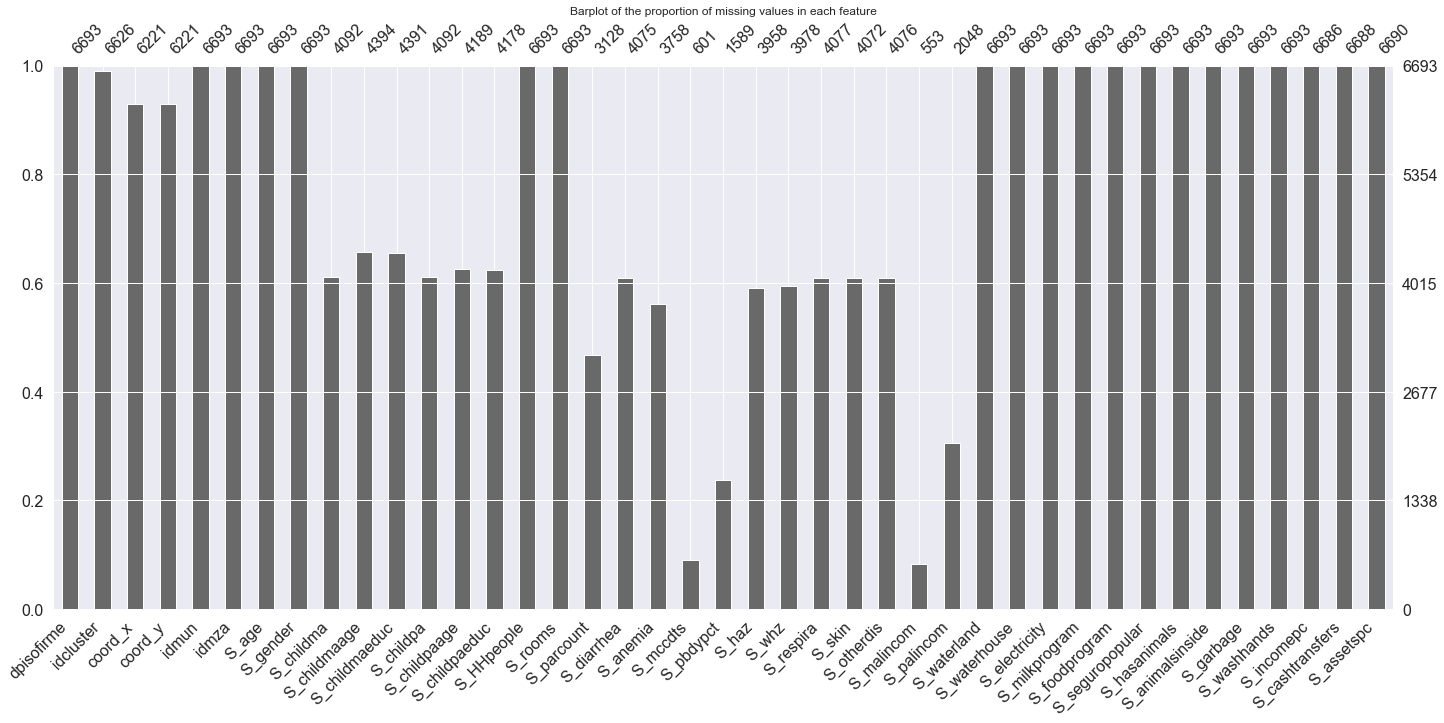

In [127]:
msno.bar(individual)
plt.title("Barplot of the proportion of missing values in each feature")
plt.show()

We can see that some features contains a very high number of missing values, as we will only be interested in children, we will check later if this is still the case for the children.

### 2) Restrict to children

#### Age distribution

In [6]:
# Find some first statistic about the age of the children 
individual['S_age'].describe()

count    6693.000000
mean       13.376364
std        14.340192
min         0.000000
25%         2.000000
50%         5.000000
75%        27.000000
max        77.000000
Name: S_age, dtype: float64

The median is at 5, which means that 50% of the data represents children under 5 years old. To visualize better where we should set the split between children and adult, we will visualize the distribution.

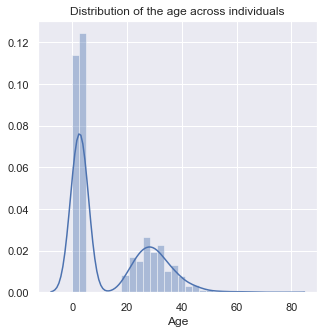

In [129]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set()
sns.distplot(individual['S_age'], bins = 30)
plt.title('Distribution of the age across individuals')
plt.xlabel('Age')
plt.show()

There is almost no individual between 10 and 20 years old. We choose to set the split at 15 years old. It guarantees that we keep at least half of the data.

In [7]:
# Creation of a dataset that contain only the children bassed on previous observation
children = individual.query('S_age < 15').copy()

print('There are', len(children.index),'children.')
print('How many missing values ?', children.isna().sum().sum())

There are 4093 children.
How many missing values ? 18949


### 3) Creation of the target for feature selection

In [131]:
#The set of features about health
#S_parcount is a continuous feature, we create a dummy variable for have parasite or not
children['has_para'] = children['S_parcount'].apply(lambda x : 1 if x >= 1 else 0).copy()
health = ['has_para', 'S_diarrhea', 'S_anemia', 'S_respira', 'S_skin', 'S_otherdis']

In [132]:
#The target will be 1 = health problem, 0 = good health
y = children[health].sum(axis = 1)
y = y.apply(lambda x : 1 if x >= 1 else 0)

In [8]:
# Describe the target:
N = len(y)
print(str(len(y))+' values, so there is no missing values in the target.')
sick = len(y[y == 1])/N*100
non_sick = len(y[y == 0])/N*100
print(str(sick)+"% of sick VS "+str(non_sick)+"% non sick.")

NameError: name 'y' is not defined

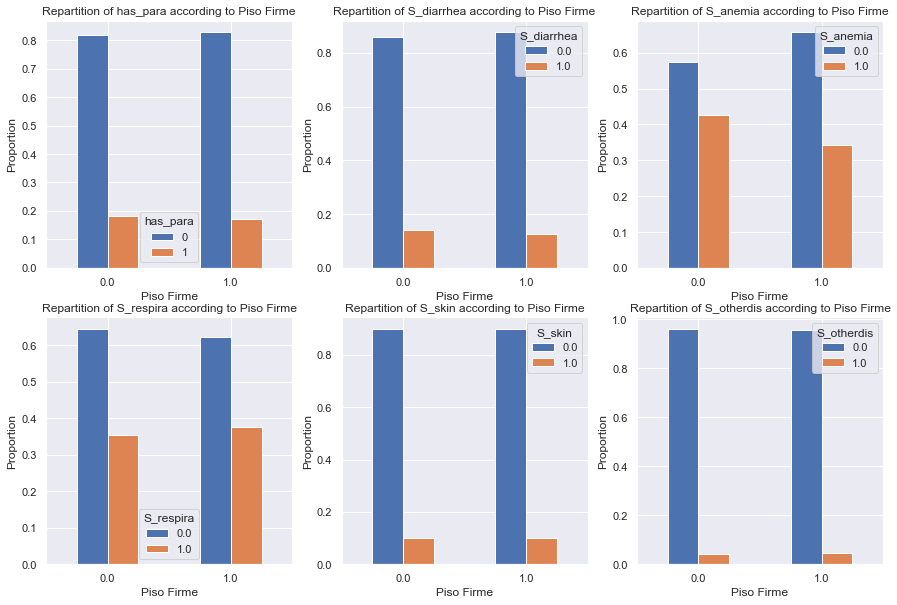

In [134]:
#Plots of  the repartition of selected features with respect to Piso Firme.
fig, axs = plt.subplots(2, 3, figsize=(15,10))
for i in range(2):
    for j in range(3):
        group = children.groupby(['dpisofirme', health[3*i+j]])[health[3*i+j]].count()
        group = group.unstack()
        group = group.div(group.sum(axis=1), axis=0)
        group.plot(kind='bar', rot=0, ax = axs[i, j])
        axs[i, j].set_title("Repartition of "+health[3*i+j]+" according to Piso Firme")
        axs[i, j].set_ylabel('Proportion')
        axs[i, j].set_xlabel('Piso Firme')
plt.show()        

In [9]:
# Add the target to the initial dataset
children['target'] = y.values

NameError: name 'y' is not defined

In [10]:
# Fisrt look of the distribution of the target with Piso Firme 
group = children.groupby(['dpisofirme', 'target'])['target'].count()
group = group.unstack()
group = group.div(group.sum(axis = 1), axis = 0)
group.plot(kind = 'bar', rot = 0)
plt.title("Repartition of healthy and unhealthy children according to Piso Firme")
plt.ylabel('Proportion')
plt.xlabel('Piso Firme')
plt.show()

KeyError: 'target'

### 4) Missing values only for children

In [137]:
# Since we are focused on the target we can drop all the other disease
children = children.drop(['has_para', 'S_parcount', 'S_diarrhea', 'S_anemia', 'S_respira', 'S_skin', 'S_otherdis'], axis = 1)

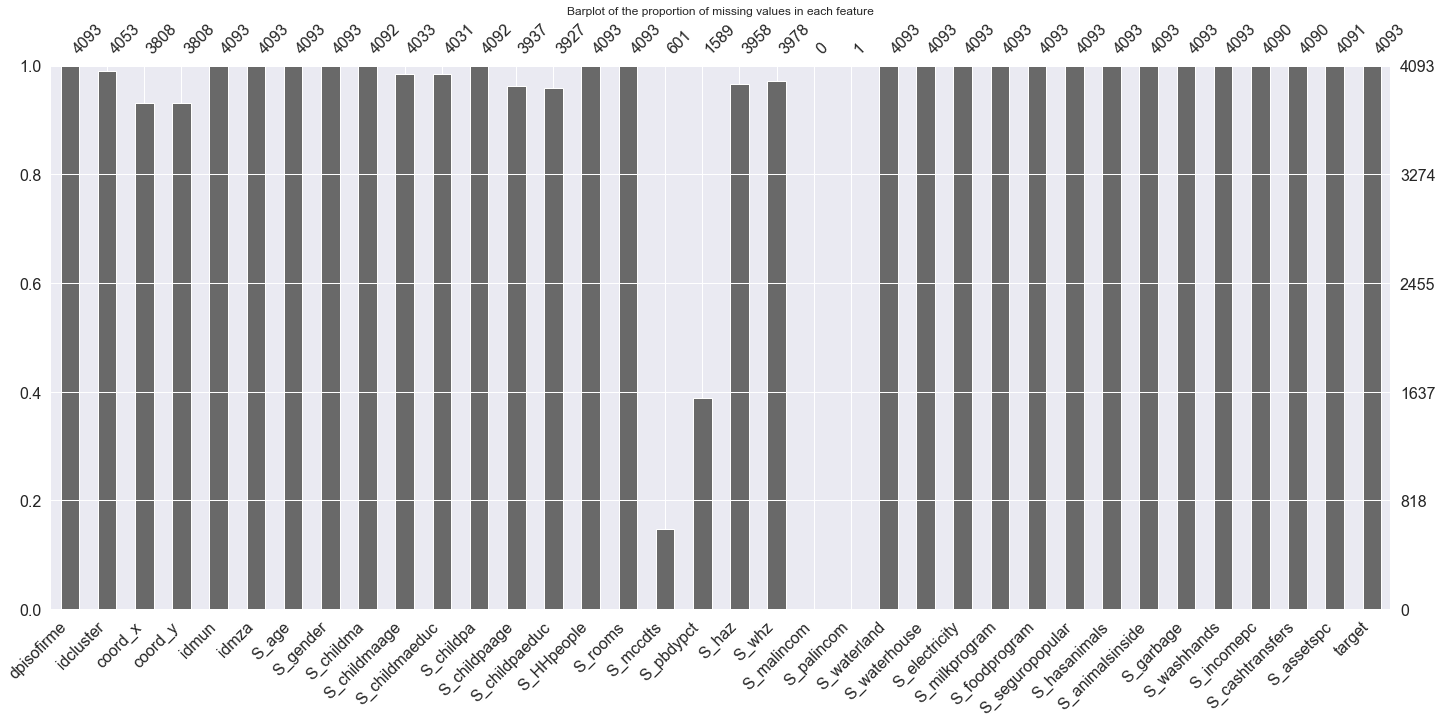

In [138]:
msno.bar(children)
plt.title("Barplot of the proportion of missing values in each feature")
plt.show()

The 2 features *S_malincom* and *S_palincom* are empty for children, these will be removed. It's also clear that *S_mccdts* and *S_pbdypct* contain also more than 50% of missing values, they will be removed too. 

In [139]:
children = children.drop(['S_malincom', 'S_palincom', 'S_mccdts', 'S_pbdypct'], axis = 1)

*coord_x* and *coord_y* are useless for our study : they kind of bias the prediction because they give direct information about control group and treatment group, and they are redundant with the feature *dpisofirme*. Same can be said for *idmun* and *idmza*. Other features have an acceptable number of missing values.

In [140]:
children = children.drop(['coord_x', 'coord_y', 'idmun', 'idmza', 'idcluster'], axis = 1)

#### Distributions

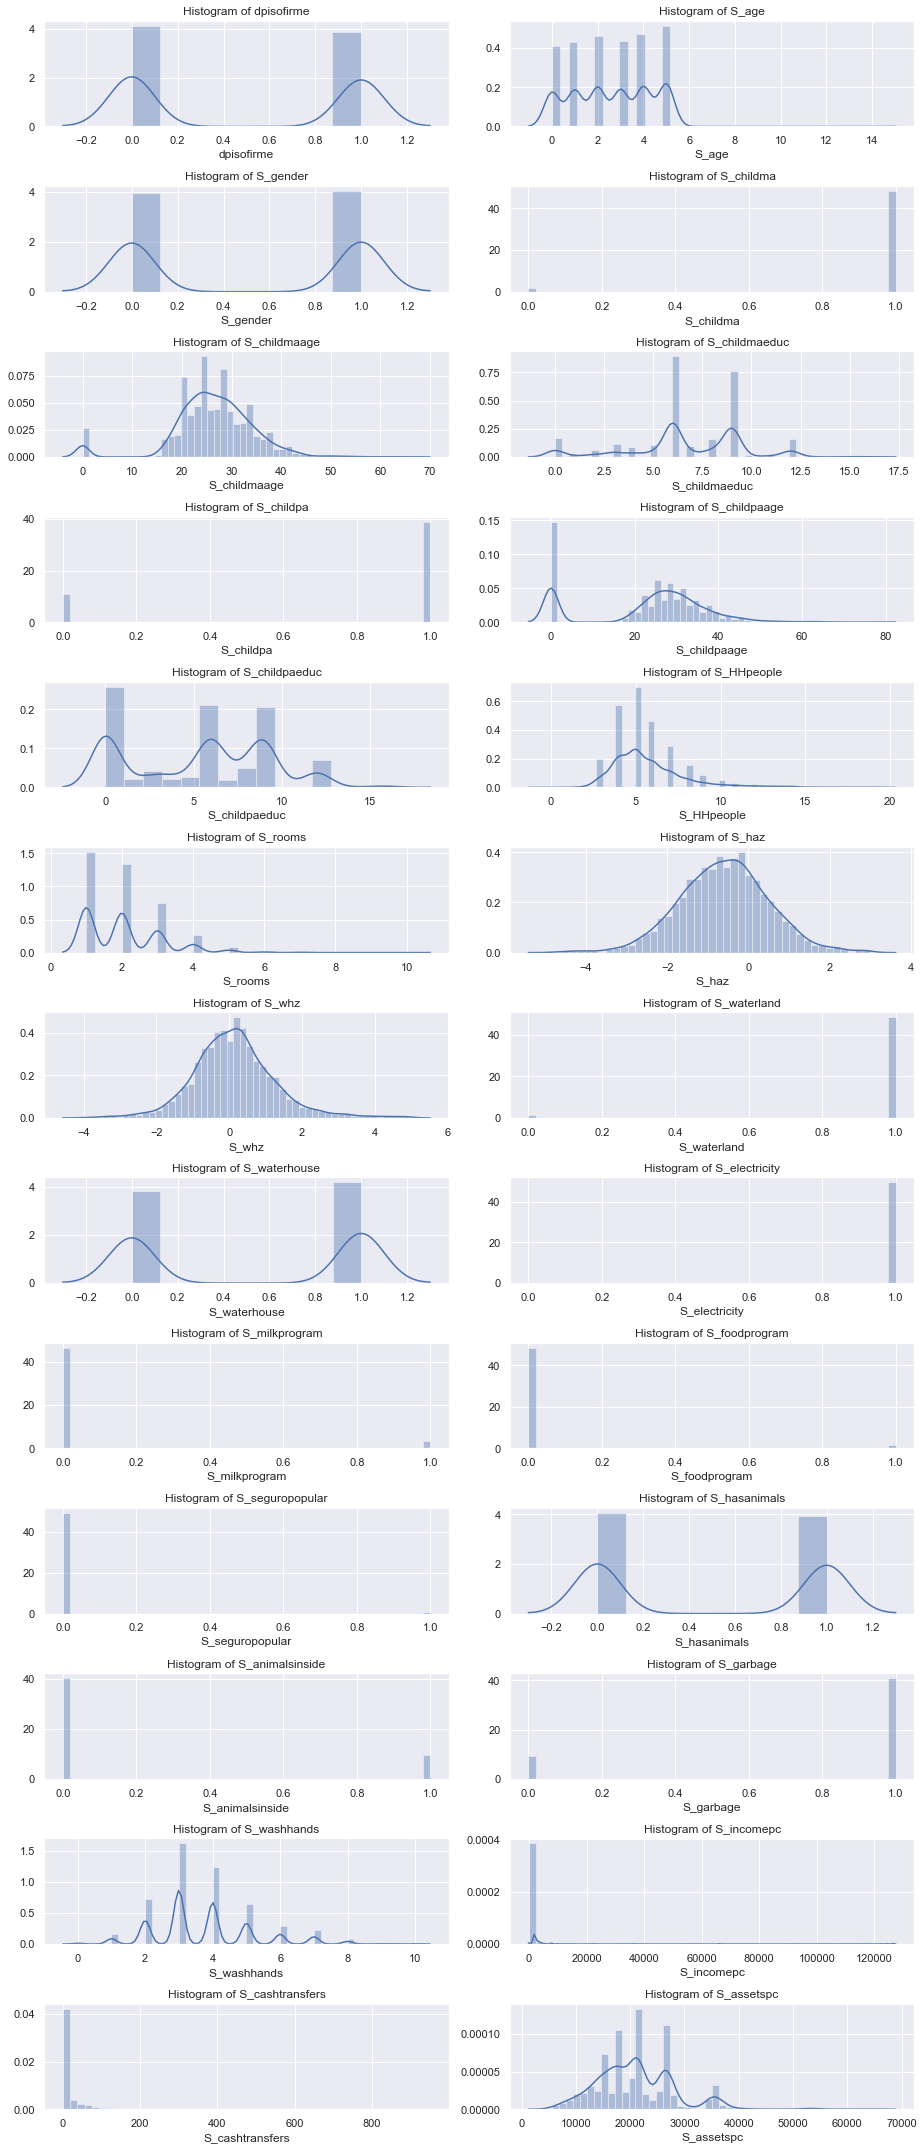

In [141]:
import warnings 
warnings.filterwarnings("ignore",category = UserWarning)
#Plot distribution of each feature
fig, axs = plt.subplots(13, 2, figsize=(13,30))
col = children.drop(['target'], axis = 1).columns
for i in range(13):
    for j in range(2):
        sns.distplot(children[col[i*2+j]],ax = axs[i,j])
        axs[i, j].set_xlabel(col[2*i+j])
        axs[i, j].set_title('Histogram of '+ str(col[2*i+j]))
fig.tight_layout(pad=1.0)

Here you can see the distribution of each features. There are still missing values in the data, we will impute these missing values with a KNN imputer, and visualize distribution again to see if something has changed. 

#### Imputation

In [142]:
#Imputation
imputer = KNNImputer()
imputer_ = imputer.fit(children)
children_ = pd.DataFrame(imputer_.transform(children))
children_.columns = children.columns

In [143]:
feature = ['S_childma', 'S_childmaage', 'S_childmaeduc', 'S_childpa', 'S_childpaage', 'S_childpaeduc']
for f in feature:
    children_[f] = children_[f].apply(lambda x : int(x) if abs(int(x)-x)<0.5 else int(x+1))

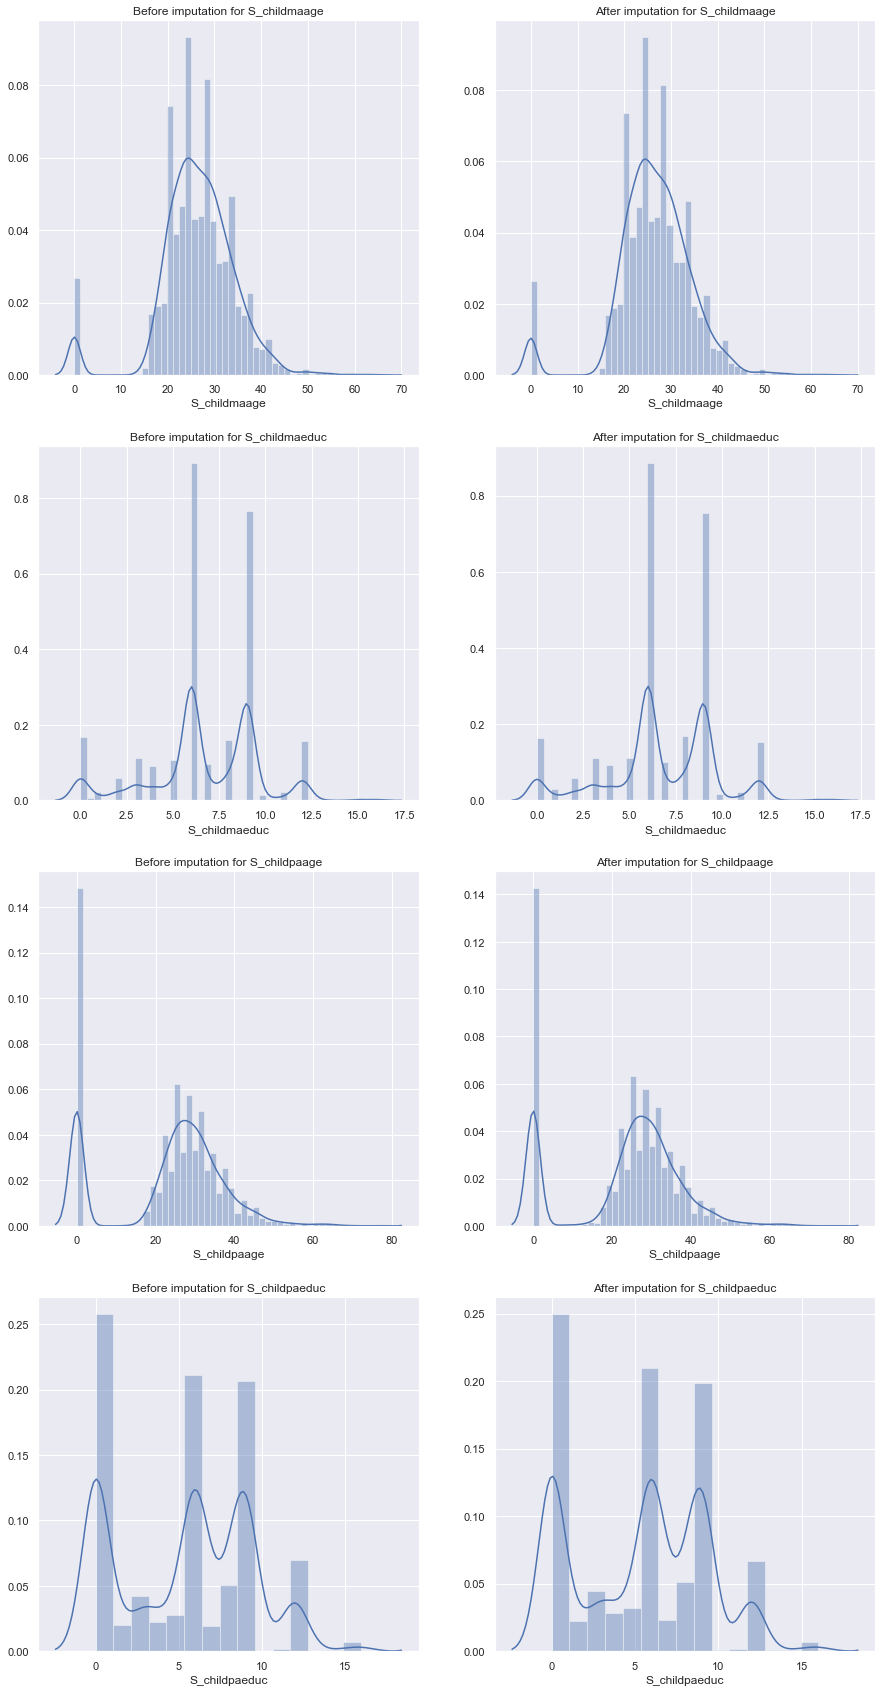

In [144]:
import warnings 
warnings.filterwarnings("ignore",category = UserWarning)

imput = ['S_childmaage', 'S_childmaeduc', 'S_childpaage', 'S_childpaeduc']
fig, axs = plt.subplots(4, 2, figsize=(15,30))
for i in range(4):
    sns.distplot(children[imput[i]],ax = axs[i,0])
    sns.distplot(children_[imput[i]], ax = axs[i, 1])
    axs[i, 0].set_xlabel(imput[i])
    axs[i, 1].set_xlabel(imput[i])
    axs[i, 0].set_title('Before imputation for '+ str(imput[i]))
    axs[i, 1].set_title('After imputation for '+ str(imput[i]))

No significant changes in distribution.

### 4) Feature engineering

By visualizing the distributions, we saw that *S_cashtransfers* and *S_incomepc* are long-tailed distributions. We will apply some transformations : apply $log(1+x)$ on *S_incomepc*  and $\sqrt(x)$ on *S_cashtransfers* to smooth the distributions. We use log(1+x) because log of x when x is zero is not defined.

In [145]:
#Log(1+x)
children_['log_S_incomepc'] = children_['S_incomepc'].apply(lambda x : np.log(1+x))
#Sqrt(x)
children_['sqrt_S_cashtransfers'] = children_['S_cashtransfers'].apply(lambda x : np.sqrt(x))

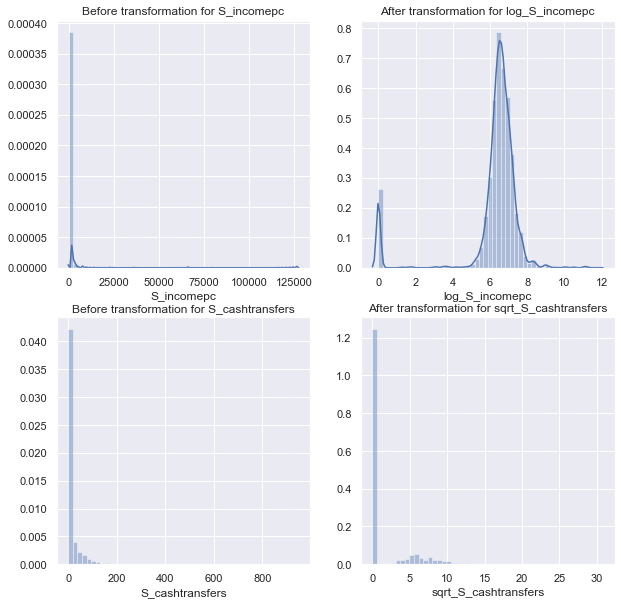

In [146]:
import warnings 
warnings.filterwarnings("ignore",category = UserWarning)

trans = ['S_incomepc', 'log_S_incomepc', 'S_cashtransfers', 'sqrt_S_cashtransfers']

fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i in range(2):
    sns.distplot(children[trans[2*i]],ax = axs[i,0])
    sns.distplot(children_[trans[2*i+1]], ax = axs[i, 1])
    axs[i, 0].set_xlabel(trans[2*i])
    axs[i, 1].set_xlabel(trans[2*i+1])
    axs[i, 0].set_title('Before transformation for '+ str(trans[2*i]))
    axs[i, 1].set_title('After transformation for '+ str(trans[2*i+1]))

#### Standardization
We set the mean to zero and the standard deviation to 1 in order to use machine learning model

In [147]:
# Some statistic before the standardization :
children_.describe()

,dpisofirme,S_age,S_gender,S_childma,S_childmaage,S_childmaeduc,S_childpa,S_childpaage,S_childpaeduc,S_HHpeople,...,S_hasanimals,S_animalsinside,S_garbage,S_washhands,S_incomepc,S_cashtransfers,S_assetspc,target,log_S_incomepc,sqrt_S_cashtransfers
count,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,...,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000
mean,0.483997,2.615685,0.504520,0.965307,26.464940,6.723675,0.780357,23.581481,5.375031,5.746152,...,0.493281,0.192768,0.817493,3.725873,992.870903,12.716282,20945.757821,0.715612,6.218493,1.599963
std,0.499805,1.722321,0.500041,0.183024,8.015598,2.920772,0.414056,14.299701,3.941450,2.227047,...,0.500016,0.394521,0.386309,1.500442,3342.295786,34.480492,7224.114172,0.451178,1.715686,3.187300
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5573.626953,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,1.000000,22.000000,6.000000,1.000000,20.000000,0.000000,4.000000,...,0.000000,0.000000,1.000000,3.000000,496.666656,0.000000,15756.987305,0.000000,6.209930,0.000000
50%,0.000000,3.000000,1.000000,1.000000,26.000000,6.000000,1.000000,27.000000,6.000000,5.000000,...,0.000000,0.000000,1.000000,3.000000,700.000000,0.000000,21003.691406,1.000000,6.552508,0.000000
75%,1.000000,4.000000,1.000000,1.000000,31.000000,9.000000,1.000000,32.000000,9.000000,7.000000,...,1.000000,0.000000,1.000000,4.000000,1028.571411,0.000000,26186.296875,1.000000,6.936898,0.000000
max,1.000000,14.000000,1.000000,1.000000,66.000000,16.000000,1.000000,77.000000,16.000000,19.000000,...,1.000000,1.000000,1.000000,10.000000,127266.664062,950.000000,64594.199219,1.000000,11.754048,30.822070


In [148]:
#Only continuous features should be normalized
to_norm = ['S_age', 'S_childmaage', 'S_childmaeduc', 'S_childpaage', 'S_childpaeduc', 'S_HHpeople', 'S_rooms',
            'S_haz', 'S_whz', 'S_washhands', 'S_incomepc', 'S_cashtransfers', 'S_assetspc']
children_[to_norm] = scale(children_[to_norm])
children_[to_norm].describe()

,S_age,S_childmaage,S_childmaeduc,S_childpaage,S_childpaeduc,S_HHpeople,S_rooms,S_haz,S_whz,S_washhands,S_incomepc,S_cashtransfers,S_assetspc
count,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03
mean,1.733825e-16,-1.631157e-16,3.447577e-17,1.980119e-16,-3.497759e-17,1.367042e-15,-1.464474e-16,4.942161e-17,6.206182e-17,5.171366e-17,-1.729214e-18,-8.327080e-16,9.419129e-17
std,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00
min,-1.518883e+00,-3.302084e+00,-2.302301e+00,-1.649291e+00,-1.363886e+00,-2.580482e+00,-9.485046e-01,-3.827817e+00,-3.688358e+00,-2.483487e+00,-2.970988e-01,-3.688415e-01,-2.128151e+00
25%,-9.382004e-01,-5.570995e-01,-2.477985e-01,-2.504890e-01,-1.363886e+00,-7.841618e-01,-9.485046e-01,-6.482807e-01,-6.149195e-01,-4.838321e-01,-1.484802e-01,-3.688415e-01,-7.183448e-01
50%,2.231649e-01,-5.801151e-02,-2.477985e-01,2.390915e-01,1.585827e-01,-3.350819e-01,-4.080544e-02,8.097206e-05,-3.418259e-02,-4.838321e-01,-8.763637e-02,-3.688415e-01,8.020452e-03
75%,8.038475e-01,5.658485e-01,7.794527e-01,5.887919e-01,9.198170e-01,5.630780e-01,8.668938e-01,6.319589e-01,5.197510e-01,1.827195e-01,1.068274e-02,-3.688415e-01,7.255117e-01
max,6.610674e+00,4.932869e+00,3.176372e+00,3.736095e+00,2.696030e+00,5.952037e+00,7.220788e+00,3.287678e+00,4.299008e+00,4.182029e+00,3.778517e+01,2.718634e+01,6.042786e+00


***
# II - What is the impact of features on children's disease ?

1. Correlation between feature and target
2. Feature selection : Pearson's correlation
3. Feature selection : Chi-2 test
4. Feature selection : LightGBM
5. Feature selection : RFE
6. Feature selection : RFECV
7. Feature selection : Random forest
8. Feature selection : Lasso regularization
9. Overview
10. Quantify feature's effect
    - Gender
    - Haz     
    - Years of education of the father
    - Cash transfers
    - Age

### 1) Correlation between features and target

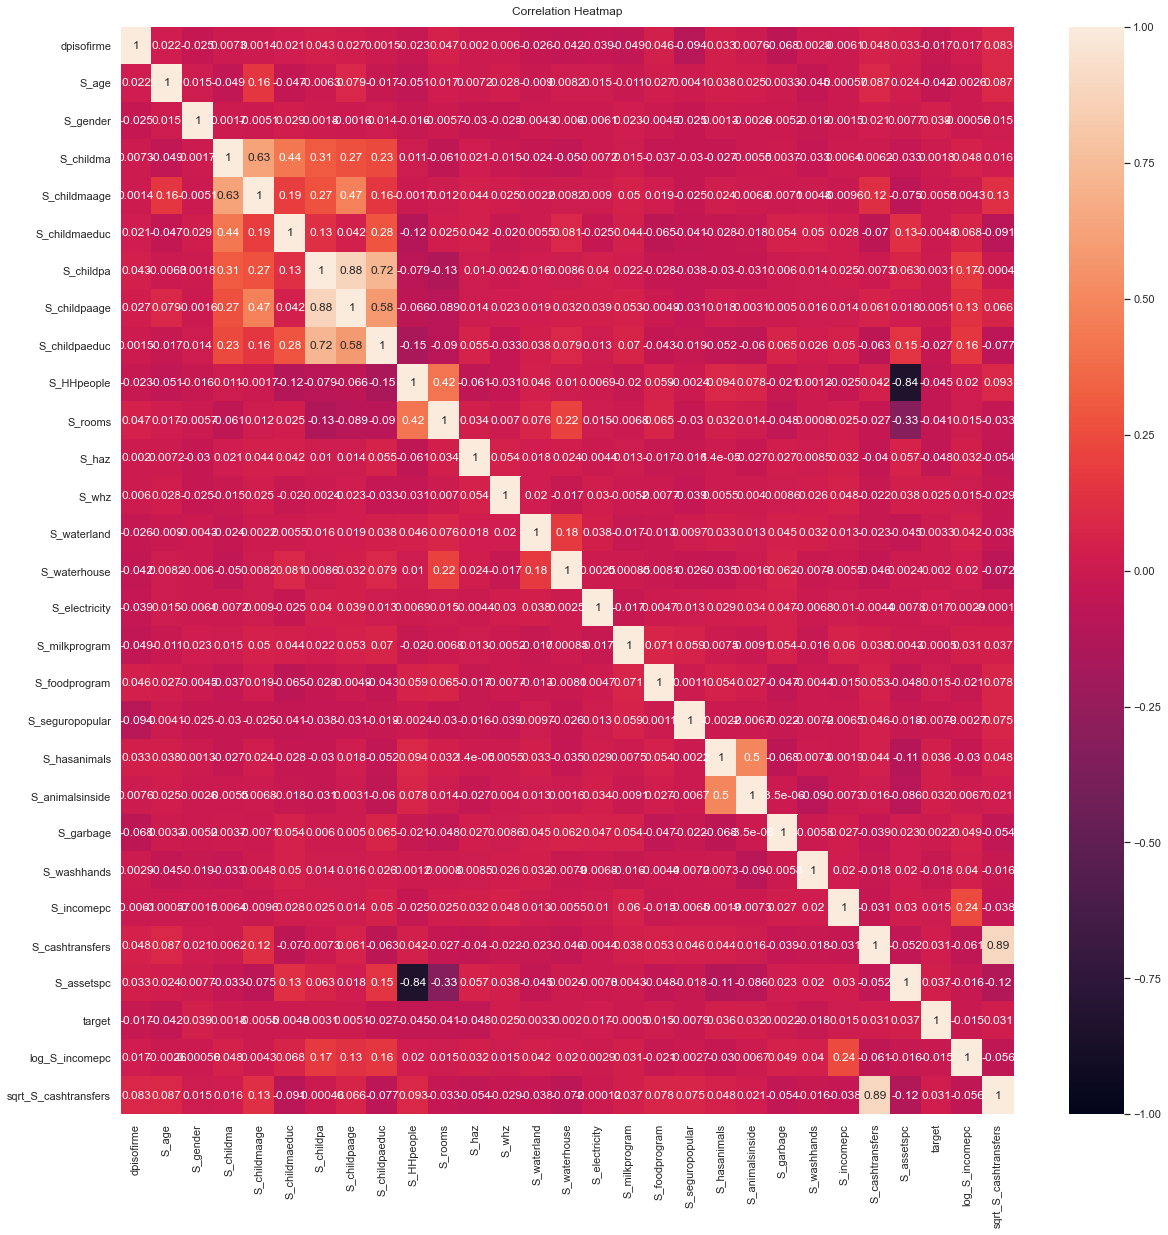

In [149]:
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(children_.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

We don't see any variable that is specifically correlated with the target. 
A strong correlation exists between features related to the mother (presence, age, years of education) and to the father (presence, age, years of education). The same thing can be said concerning the presence of animals outside and/or inside. 

In [150]:
X = children_.drop(['target', 'S_cashtransfers', 'S_incomepc'], axis = 1).copy()

### 2) Pearson's correlation

This method uses Pearson's correlation between features and the target to establish a ranking. Then one can decide the number of features to select. 

In [151]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y, rowvar = False)[0, 1]
        cor_list.append(cor)
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [152]:
cor_support, cor_feature = cor_selector(X, y, 15)
print(str(len(cor_feature)), 'selected features')
print("Selected features :", cor_feature)

15 selected features
Selected features : ['log_S_incomepc', 'S_electricity', 'dpisofirme', 'S_washhands', 'S_whz', 'S_childpaeduc', 'sqrt_S_cashtransfers', 'S_animalsinside', 'S_hasanimals', 'S_assetspc', 'S_gender', 'S_rooms', 'S_age', 'S_HHpeople', 'S_haz']


### 3) Chi-2

Using a similar idea as the previous method but here with a Chi-2 test.

In [153]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

def chi_2(X, y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    return chi_support, chi_feature

In [154]:
chi_support, chi_feature = chi_2(X, y, 15)
print(str(len(chi_feature)), 'selected features')
print("Selected features :", chi_feature)

15 selected features
Selected features : ['dpisofirme', 'S_age', 'S_gender', 'S_childpaeduc', 'S_HHpeople', 'S_rooms', 'S_haz', 'S_whz', 'S_foodprogram', 'S_seguropopular', 'S_hasanimals', 'S_animalsinside', 'S_washhands', 'S_assetspc', 'sqrt_S_cashtransfers']


### 4) LightGBM

LightGBM is a tree based algorithm, it's a boosting framework that uses decision tree learning.

In [155]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

def lightgbm(X, y, num_feat):
    lgbc=LGBMClassifier(n_estimators=1000, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feat)
    embeded_lgb_selector.fit(X, y)

    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    return embeded_lgb_support, embeded_lgb_feature

In [156]:
embeded_lgb_support, embeded_lgb_feature = lightgbm(X, y, 15)
print(str(len(embeded_lgb_feature)), 'selected features')
print("Selected features :", embeded_lgb_feature)

9 selected features
Selected features : ['S_age', 'S_childmaage', 'S_childmaeduc', 'S_childpaage', 'S_childpaeduc', 'S_haz', 'S_whz', 'S_assetspc', 'log_S_incomepc']


### 5) RFE

Recursive feature elimination is a backward selection of predictors, it starts considering the entire set of predictors and computing an importance score for each of the predictors. At each iteration, the less important predictors are removed and the model is rebuilt. 

In [157]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

def rfe(X, y, num_feat):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(max_iter = 5000), n_features_to_select=num_feat, step=10, verbose=5)
    rfe_selector.fit(X_norm, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    return rfe_support, rfe_feature

In [158]:
rfe_support, rfe_feature = rfe(X, y, 15)
print(str(len(rfe_feature)), 'selected features')
print("Selected features :", rfe_feature)

Fitting estimator with 26 features.
Fitting estimator with 16 features.
15 selected features
Selected features : ['S_age', 'S_gender', 'S_childpa', 'S_childpaeduc', 'S_HHpeople', 'S_rooms', 'S_haz', 'S_whz', 'S_electricity', 'S_foodprogram', 'S_seguropopular', 'S_hasanimals', 'S_washhands', 'S_assetspc', 'sqrt_S_cashtransfers']


### 6) RFECV

Variant here : includes cross-validation.

In [159]:
from sklearn.feature_selection import RFECV

def rfecv(X, y):
    selector = RFECV(estimator = LogisticRegression(), step=1, cv=5, min_features_to_select = 10)
    selector = selector.fit(X, y)
    rfecv_support = selector.get_support()
    rfecv_feature = X.loc[:, rfecv_support].columns.tolist()
    return rfecv_support, rfecv_feature

In [160]:
rfecv_support, rfecv_feature = rfecv(X, y)
print(str(len(rfecv_feature)), 'selected features')
print("Selected features :", rfecv_feature)

23 selected features
Selected features : ['dpisofirme', 'S_age', 'S_gender', 'S_childma', 'S_childmaage', 'S_childpa', 'S_childpaage', 'S_childpaeduc', 'S_HHpeople', 'S_rooms', 'S_haz', 'S_whz', 'S_waterland', 'S_waterhouse', 'S_electricity', 'S_foodprogram', 'S_seguropopular', 'S_hasanimals', 'S_animalsinside', 'S_garbage', 'S_washhands', 'S_assetspc', 'sqrt_S_cashtransfers']


### 7) Random Forests

In [161]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

def rf(X, y, num_feat):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=500), max_features=num_feat)
    embeded_rf_selector.fit(X, y)
    
    feature_scores = pd.Series(embeded_rf_selector.estimator_.feature_importances_, index = X.columns).sort_values(ascending = False)
    f, ax = plt.subplots(figsize=(30, 24))
    ax = sns.barplot(x = feature_scores, y = feature_scores.index)
    ax.set_title("Visualize feature scores of the features",fontsize=30)
    ax.set_yticklabels(feature_scores.index)
    ax.set_xlabel("Feature importance score",fontsize=30)
    ax.yaxis.set_tick_params(labelsize = 25)
    ax.xaxis.set_tick_params(labelsize = 25)
    ax.set_ylabel("Features",fontsize=30)
    plt.show()
    
    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    return embeded_rf_support, embeded_rf_feature

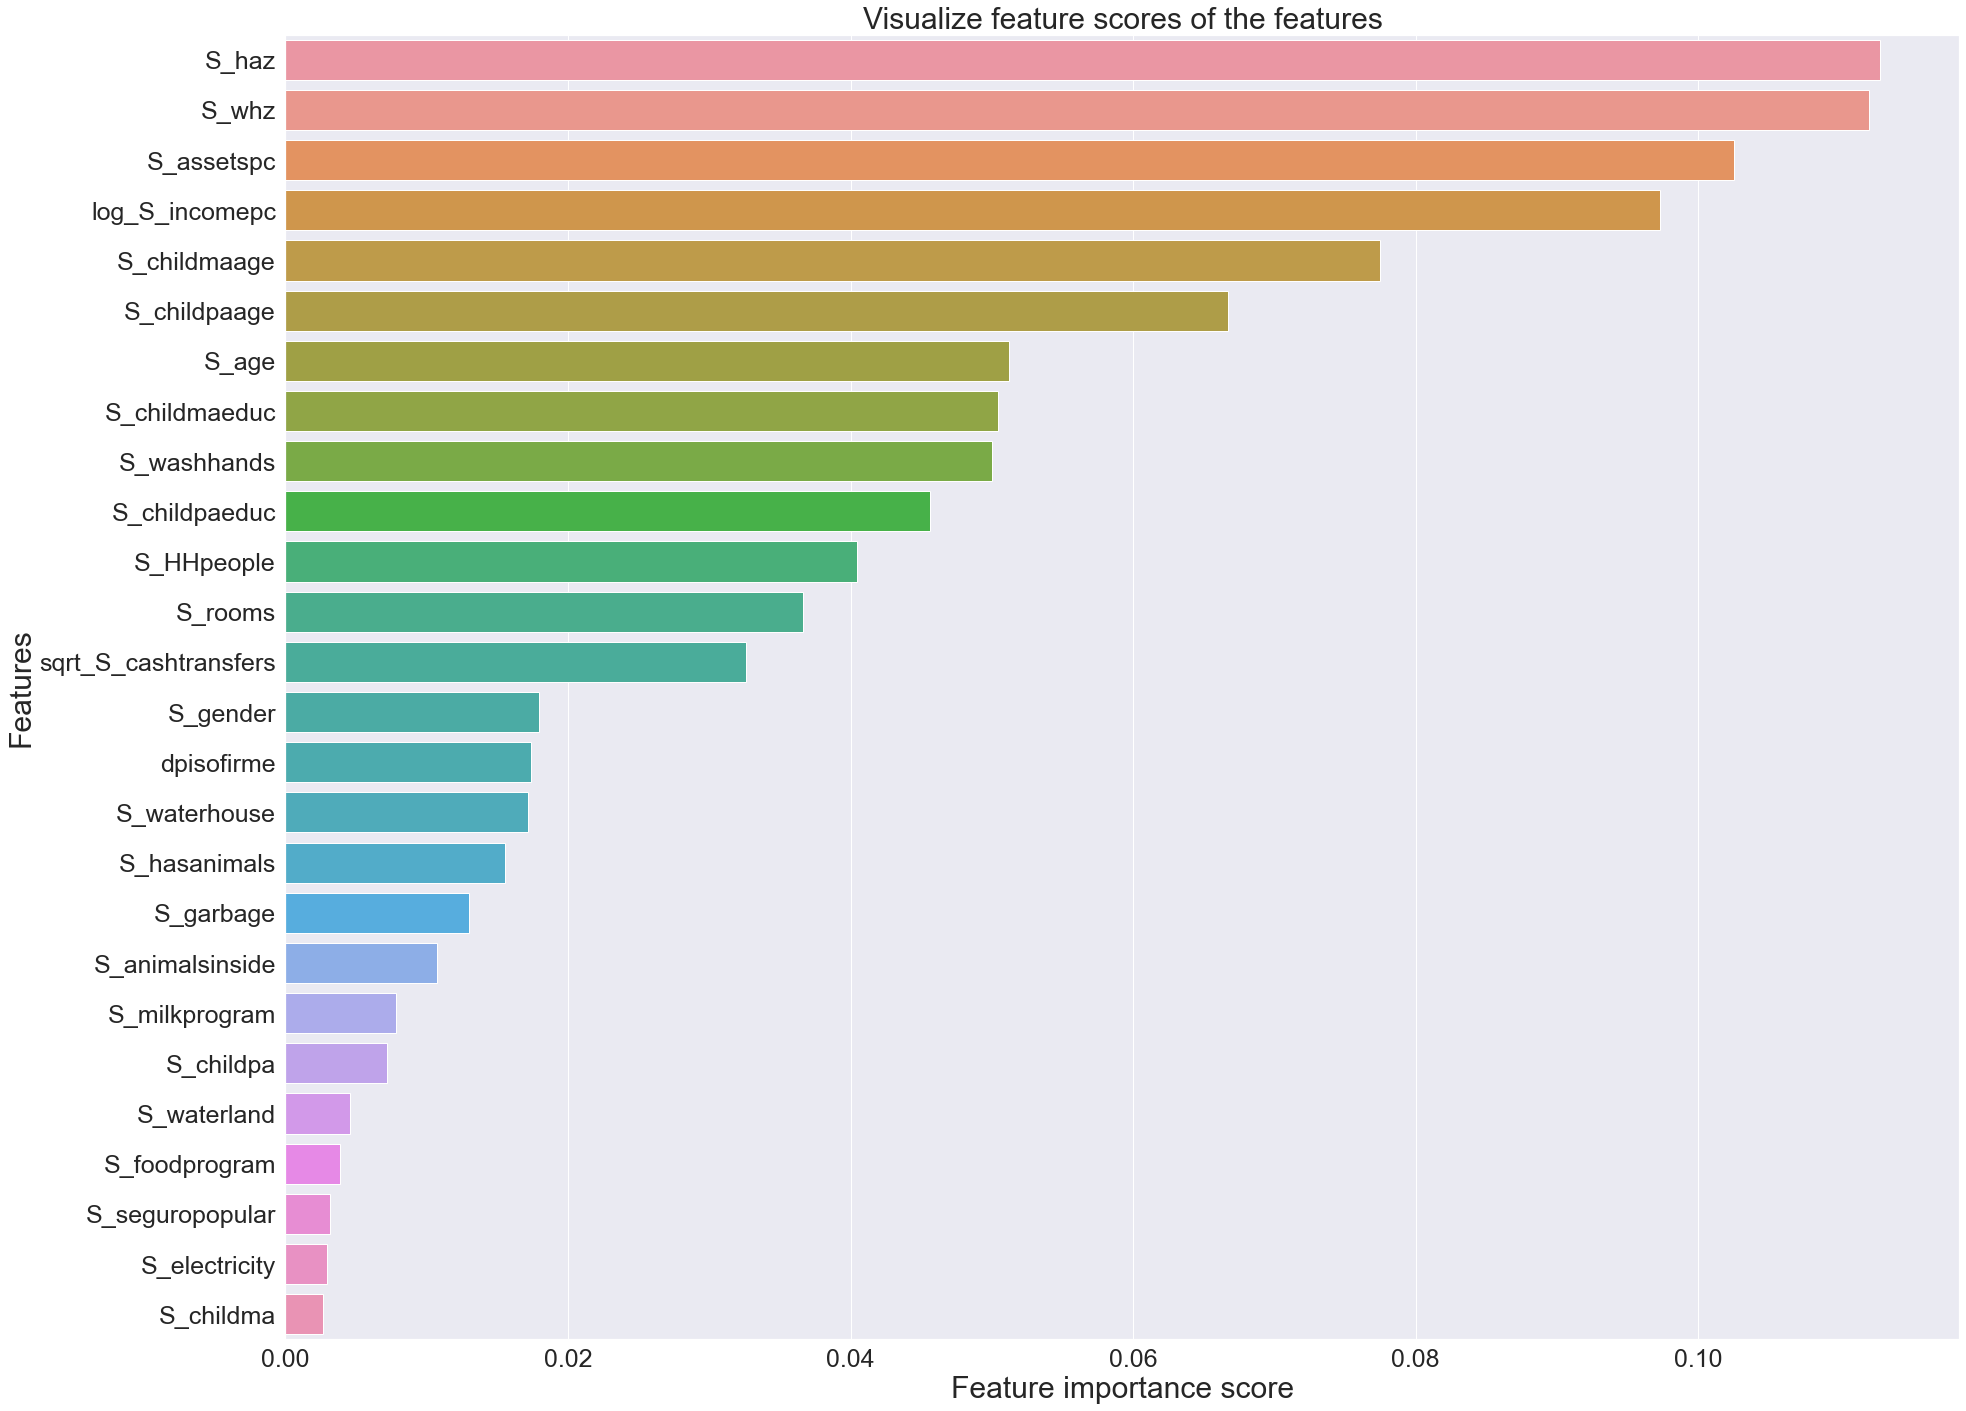

11 selected features
Selected features : ['S_age', 'S_childmaage', 'S_childmaeduc', 'S_childpaage', 'S_childpaeduc', 'S_HHpeople', 'S_haz', 'S_whz', 'S_washhands', 'S_assetspc', 'log_S_incomepc']


In [162]:
embeded_rf_support, embeded_rf_feature = rf(X, y, 15)
print(str(len(embeded_rf_feature)), 'selected features')
print("Selected features :", embeded_rf_feature)

### 8) Lasso regularization

In [163]:
from sklearn.linear_model import LassoCV, Lasso

def lasso(X, y):
    reg = LassoCV()
    reg_ = reg.fit(X, y)
    print("Best alpha using built-in LassoCV: %f" % reg_.alpha_)
    print("Best score using built-in LassoCV: %f" %reg_.score(X, y))
    coef = pd.Series(reg_.coef_, index = X.columns)
    print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  
          str(sum(coef == 0)) + " variables")
    sns.set()
    imp_coef = coef.sort_values()
    import matplotlib
    matplotlib.rcParams['figure.figsize'] = (5, 5)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using Lasso Model")
    plt.show()

    kept = imp_coef[[imp_coef[i] != 0 for i in range(len(imp_coef))]]
    lasso_feature = [(i in kept) for i in X.columns]
    lasso_support = X.columns.tolist()
    return lasso_support, lasso_feature

Best alpha using built-in LassoCV: 0.003830
Best score using built-in LassoCV: 0.012575
Lasso picked 15 variables and eliminated the other 11 variables


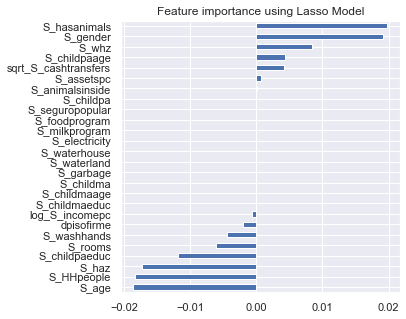

In [164]:
lasso_support, lasso_feature = lasso(X, y)

### 9) Overview

In [165]:
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':X.columns, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'RFECV': rfecv_support, 'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support, 'Lasso':lasso_feature})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(29)

,Feature,Pearson,Chi-2,RFE,RFECV,Random Forest,LightGBM,Lasso,Total
1,S_whz,True,True,True,True,True,True,True,7
2,S_haz,True,True,True,True,True,True,True,7
3,S_childpaeduc,True,True,True,True,True,True,True,7
4,S_assetspc,True,True,True,True,True,True,True,7
5,S_age,True,True,True,True,True,True,True,7
6,S_washhands,True,True,True,True,True,False,True,6
7,S_HHpeople,True,True,True,True,True,False,True,6
8,sqrt_S_cashtransfers,True,True,True,True,False,False,True,5
9,S_rooms,True,True,True,True,False,False,True,5
10,S_hasanimals,True,True,True,True,False,False,True,5


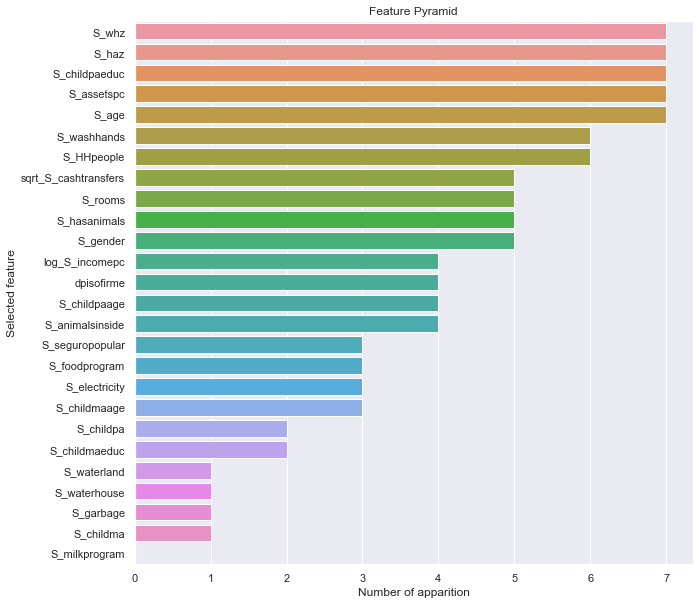

In [166]:
to_plot = pd.DataFrame({'Features': feature_selection_df['Feature'],
                       '#_apparition' : feature_selection_df['Total']})

plt.figure(figsize = (10,10))
bar_plot = sns.barplot(x='#_apparition', y='Features', data=to_plot)
bar_plot.set(xlabel="Number of apparition", ylabel="Selected feature", title = "Feature Pyramid")
plt.show()

We can see that the most important features in determining if a children is healthy or not, are **S_whz**, **S_washhands**, **S_haz**, **S_childpaeduc** and **S_assetspc**. 

### 10) Quantify feature's effect
Using the 15th first features selected with the feature selection methods, we will fit a logistic regression and analyze the effect of each feature in the prediction of a disease in children. We select the most important features that we have selected previously

In [167]:
top_features = feature_selection_df['Feature'][:15].tolist()

In [168]:
#Building the model
log_reg = smf.logit(formula = 'target ~ C(dpisofirme) + S_whz + S_washhands + S_haz + S_childpaeduc + S_assetspc + \
                                sqrt_S_cashtransfers + S_age + S_HHpeople + log_S_incomepc + S_rooms + C(S_hasanimals) + \
                                C(S_gender) + S_childpaage + C(S_animalsinside)', data = children_)
res = log_reg.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.589761
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 4093
Model:                          Logit   Df Residuals:                     4077
Method:                           MLE   Df Model:                           15
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                 0.01221
Time:                        11:47:29   Log-Likelihood:                -2413.9
converged:                       True   LL-Null:                       -2443.7
Covariance Type:            nonrobust   LLR p-value:                 2.876e-07
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.8206      0.150      5.472      0.000       0.

In [169]:
print("Statistically significant features based on the p-values for the logistic regression are :")
print(res.pvalues.apply(lambda x : x < 0.05))

Statistically significant features based on the p-values for the logistic regression are :
Intercept                     True
C(dpisofirme)[T.1.0]         False
C(S_hasanimals)[T.1.0]       False
C(S_gender)[T.1.0]            True
C(S_animalsinside)[T.1.0]    False
S_whz                        False
S_washhands                  False
S_haz                         True
S_childpaeduc                 True
S_assetspc                   False
sqrt_S_cashtransfers          True
S_age                         True
S_HHpeople                   False
log_S_incomepc               False
S_rooms                      False
S_childpaage                 False
dtype: bool


Here we can see that some features effect significally the dieases in children :
 - **Gender** : boys or girls 
 - **haz** 
 - **childpaeduc** : the number of education years of the father
 - **cashtransfers** 
 - **age** : children age

Let's take a deeper look of the implication of these features :

##### a) Effect of the Gender 

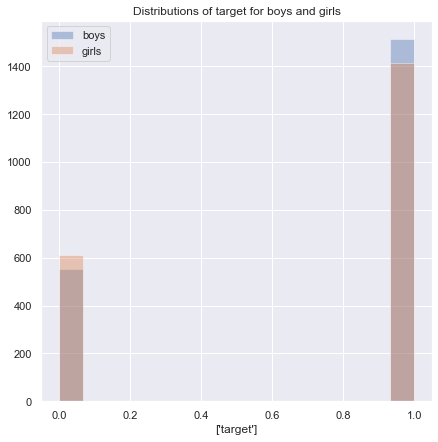

In [170]:
#Data
boys = children_[children_['S_gender'] == 1]
girls = children_[children_['S_gender'] == 0]

feature = ['target']

#Graphical set up
plt.figure(figsize = (7, 7))
sns.distplot(boys[feature], bins = 15, kde = False, axlabel = feature)
sns.distplot(girls[feature], bins = 15, kde = False, axlabel = feature)
plt.title('Distributions of '+ feature[0] +' for boys and girls')
plt.legend(['boys', 'girls'])
plt.show()

In [171]:
from statsmodels.stats.proportion import proportions_ztest

# can we assume anything from our sample
significance = 0.05

# note - the samples do not need to be the same size
nb_sick_treat, sample_size_treat = (boys.target.sum(), len(boys))
nb_sick_control, sample_size_control = (girls.target.sum(), len(girls))

print("Number of sick in the treatment group",nb_sick_treat)
print("Number of people in the treatment group",sample_size_treat)
print("Number of sick in the control group",nb_sick_control)
print("Number of sick in the control group",sample_size_control)

# check our sample against Ho for Ha != Ho
successes = np.array([nb_sick_treat, nb_sick_control])
samples = np.array([sample_size_treat, sample_size_control])

stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')

# report
print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))

print("Conclusion :")
if p_value > significance:
    print("   Fail to reject the null hypothesis - we have nothing else to say")
else:
    print("   Reject the null hypothesis - suggest the alternative hypothesis is true")

Number of sick in the treatment group 1514.0
Number of people in the treatment group 2065
Number of sick in the control group 1415.0
Number of sick in the control group 2028
z_stat: 2.513, p_value: 0.012
Conclusion :
   Reject the null hypothesis - suggest the alternative hypothesis is true


In [172]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return np.abs(propensity_score1-propensity_score2)

In [173]:
def bootstrap_CI_mean(data, nbr_draws):
    mean = np.zeros(nbr_draws)
    data = np.array(data)
    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices]
        mean[n] = np.nanmean(data_tmp)
    
    return [np.nanpercentile(mean, 2.5),np.nanpercentile(mean, 97.5)]

In [182]:
def observational_studies(features_to_test):
    tmp_df = children_.copy()
    top_features = feature_selection_df['Feature'][:10].tolist()
    
    # Compute the propensities scores :
    predictors = 'target'
    for feat in top_features:
        if not feat==features_to_test :
            predictors += '+'+feat
            
    #Building the model
    log_reg = smf.logit(formula = features_to_test+ ' ~'+ predictors , data = tmp_df)
    res = log_reg.fit()

    tmp_df['Propensity_scores'] = res.predict()
    
    #The matching :
    #Separate the treatment and control groups
    treatment_df = tmp_df[tmp_df[features_to_test] == 1]
    control_df = tmp_df[tmp_df[features_to_test] == 0]

    #List of index
    idx_tr= []
    idx_co = []

    #Threshold
    epsilon = 0.05
    
    print("Matching calculation ...")
    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():

                similarity = get_similarity(control_row['Propensity_scores'],treatment_row['Propensity_scores'])

                if (similarity < epsilon) and treatment_id not in idx_tr and control_id not in idx_co:
                    idx_tr.append(treatment_id)
                    idx_co.append(control_id)
    
    print("***************************************************")
    
    #Select the pairs in the original dataset
    matching_non = tmp_df.loc[idx_tr +idx_co ]

    treat_match = tmp_df.loc[idx_tr]
    control_match = tmp_df.loc[idx_co]
    
    print("Information matching ...")
    print("   There are :",len(treatment_df)," in the treatement groupe ")
    print("   There are :",len(control_df)," in the control groupe ")
    print("   There are :",len(idx_tr)," pair of matching  ")
    print("   Thus there are :", min(len(treatment_df)-len(idx_tr),len(control_df)-len(idx_tr))," of non match pair ")
    print("***************************************************")
    
    #Compute the ATE 
    diff_tr_co = treat_match.target.values-control_match.target.values
    ATE = np.mean(diff_tr_co)
    CI = bootstrap_CI_mean(diff_tr_co,500)
    print("ATE calculation ...")
    print("   The estimated ATE is : ",ATE )
    print("   The 95% CI is : [", round(CI[0],3),",",round(CI[1],3),"]")
    print("***************************************************")
    print("Conclusion ...")
    if CI[0]*CI[1]<0 :
        print("   It seems that ",features_to_test," has no effect on the children disease ")
    else :
        print("   It seems that ",features_to_test," could have some effect on the children disease ")
        
    return treat_match , control_match

In [175]:
treat_ , control_ = observational_studies('S_gender')

Optimization terminated successfully.
         Current function value: 0.690978
         Iterations 4
Matching calculation ...
***************************************************
Information matching ...
   There are : 2065  in the treatement groupe 
   There are : 2028  in the control groupe 
   There are : 2028  pair of matching  
   Thus there are : 0  of non match pair 
***************************************************
ATE calculation ...
   The estimated ATE is :  0.03648915187376726
   The 95% CI is : [ 0.013 , 0.062 ]
***************************************************
Conclusion ...
   It seems that  S_gender  could have some effect on the children disease 


##### b) Effect of Haz

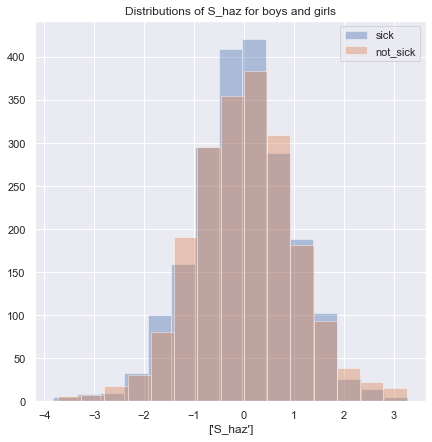

In [176]:
#Data
sick = children_[children_['target'] == 1]
not_sick = children_[children_['target'] == 0]

feature = ['S_haz']

#Graphical set up
plt.figure(figsize = (7, 7))
sns.distplot(boys[feature], bins = 15, kde = False, axlabel = feature)
sns.distplot(girls[feature], bins = 15, kde = False, axlabel = feature)
plt.title('Distributions of '+ feature[0] +' for boys and girls')
plt.legend(['sick', 'not_sick'])
plt.show()

To show that the mean are not equale for the two different subgroup. We can use a T-test, in fact an assumption of the T-test is that the distribution have to be normal which seems to be respected here 

$H_0$ : mean of accepted and rejected are equals 

$H_1$ : mean of accepted is larger than mean rejected 

In [177]:
from statsmodels.stats.weightstats import ttest_ind
#Some stats before the test
print("Number of samples sick :", len(sick.index))
print("Number of samples not sick :", len(not_sick.index))
print("Standard deviation of samples accepted :", sick['S_haz'].std(axis = 0))
print("Standard deviation of samples rejected :", not_sick['S_haz'].std(axis = 0))

# As we see that standard deviation are not equal for both samples we fixe usevar as unequal 
# Then we set value as 0 because the null hyptoesis implies a difference of mean that is 0
# Finaly be definition of the alternative hypothesis we fixe alternative as larger. 

test = ttest_ind(sick['S_haz'], not_sick['S_haz'], alternative='two-sided')

print("The t-value is ", test[0])
print("The p-value is ", test[1])

Number of samples sick : 2929
Number of samples not sick : 1164
Standard deviation of samples accepted : 1.002414607792259
Standard deviation of samples rejected : 0.9907089833407536
The t-value is  -3.061101057341493
The p-value is  0.0022195600223274487


Thus we can reject the null hypotehesis. There is some statistical evidence that a lower **haz** shows a predisposition to be sick 

##### c) Effect of education of the father

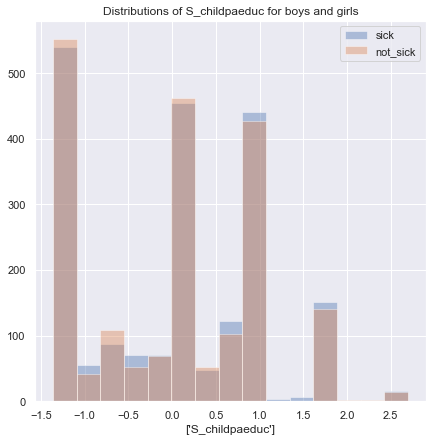

In [178]:
#Data
sick = children_[children_['target'] == 1]
not_sick = children_[children_['target'] == 0]

feature = ['S_childpaeduc']

#Graphical set up
plt.figure(figsize = (7, 7))
sns.distplot(boys[feature], bins = 15, kde = False, axlabel = feature)
sns.distplot(girls[feature], bins = 15, kde = False, axlabel = feature)
plt.title('Distributions of '+ feature[0] +' for boys and girls')
plt.legend(['sick', 'not_sick'])
plt.show()

In [179]:
from statsmodels.stats.weightstats import ttest_ind
#Some stats before the test
print("Number of samples sick :", len(sick.index))
print("Number of samples not sick :", len(not_sick.index))
print("Standard deviation of samples accepted :", sick['S_childpaeduc'].std(axis = 0))
print("Standard deviation of samples rejected :", not_sick['S_childpaeduc'].std(axis = 0))

# As we see that standard deviation are not equal for both samples we fixe usevar as unequal 
# Then we set value as 0 because the null hyptoesis implies a difference of mean that is 0
# Finaly be definition of the alternative hypothesis we fixe alternative as larger. 

test = ttest_ind(sick['S_childpaeduc'], not_sick['S_childpaeduc'], alternative='two-sided')

print("The t-value is ", test[0])
print("The p-value is ", test[1])

Number of samples sick : 2929
Number of samples not sick : 1164
Standard deviation of samples accepted : 0.9991641557626405
Standard deviation of samples rejected : 1.0016530048778427
The t-value is  -1.7450984767406903
The p-value is  0.0810428108866886


We cannot reject the null hypothesis thus their is not statistical evidence that the education of the father have an impact on the children's health

##### d) Effect of cash transfers

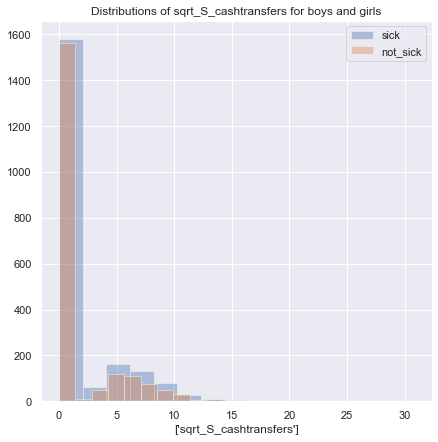

In [180]:
#Data
sick = children_[children_['target'] == 1]
not_sick = children_[children_['target'] == 0]

feature = ['sqrt_S_cashtransfers']

#Graphical set up
plt.figure(figsize = (7, 7))
sns.distplot(boys[feature], bins = 15, kde = False, axlabel = feature)
sns.distplot(girls[feature], bins = 15, kde = False, axlabel = feature)
plt.title('Distributions of '+ feature[0] )
plt.legend(['sick', 'not_sick'])
plt.show()

In [181]:
from statsmodels.stats.weightstats import ttest_ind
#Some stats before the test
print("Number of samples sick :", len(sick.index))
print("Number of samples not sick :", len(not_sick.index))
print("Standard deviation of samples accepted :", sick['sqrt_S_cashtransfers'].std(axis = 0))
print("Standard deviation of samples rejected :", not_sick['sqrt_S_cashtransfers'].std(axis = 0))

# As we see that standard deviation are not equal for both samples we fixe usevar as unequal 
# Then we set value as 0 because the null hyptoesis implies a difference of mean that is 0
# Finaly be definition of the alternative hypothesis we fixe alternative as larger. 

test = ttest_ind(sick['sqrt_S_cashtransfers'], not_sick['sqrt_S_cashtransfers'], alternative='two-sided')

print("The t-value is ", test[0])
print("The p-value is ", test[1])

Number of samples sick : 2929
Number of samples not sick : 1164
Standard deviation of samples accepted : 3.2603974701886598
Standard deviation of samples rejected : 2.991235528133579
The t-value is  1.9602495949779293
The p-value is  0.0500344000051571


We cannot reject the null hypothesis, thus cash transfert from gouvernemental program doesn't seem to improve the children's health

##### e) Effect of the age

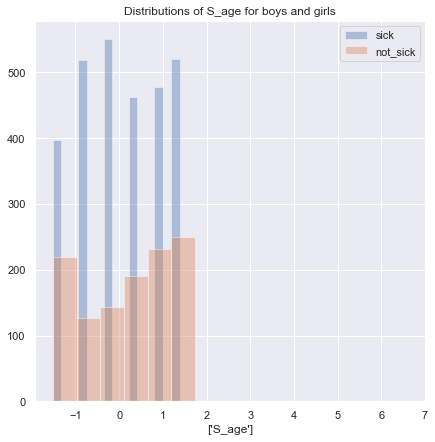

In [83]:
#Data
sick = children_[children_['target'] == 1]
not_sick = children_[children_['target'] == 0]

feature = ['S_age']

#Graphical set up
plt.figure(figsize = (7, 7))
sns.distplot(boys[feature], bins = 15, kde = False, axlabel = feature)
sns.distplot(girls[feature], bins = 15, kde = False, axlabel = feature)
plt.title('Distributions of '+ feature[0] )
plt.legend(['sick', 'not_sick'])
plt.show()

In [84]:
from statsmodels.stats.weightstats import ttest_ind
#Some stats before the test
print("Number of samples sick :", len(sick.index))
print("Number of samples not sick :", len(not_sick.index))
print("Standard deviation of samples accepted :", sick['S_age'].std(axis = 0))
print("Standard deviation of samples rejected :", not_sick['S_age'].std(axis = 0))

# As we see that standard deviation are not equal for both samples we fixe usevar as unequal 
# Then we set value as 0 because the null hyptoesis implies a difference of mean that is 0
# Finaly be definition of the alternative hypothesis we fixe alternative as larger. 

test = ttest_ind(sick['S_age'], not_sick['S_age'], alternative='two-sided')

print("The t-value is ", test[0])
print("The p-value is ", test[1])

Number of samples sick : 2929
Number of samples not sick : 1164
Standard deviation of samples accepted : 0.9729454176096094
Standard deviation of samples rejected : 1.0629306988118585
The t-value is  -2.7046938147164283
The p-value is  0.006865047527251382


We can reject the null hypothesis and conclude that the age of the children have a statisticaly significant impact on the children's health

##### f) effect of having animals 

In [184]:
treat_ , control_ = observational_studies('S_hasanimals')

Optimization terminated successfully.
         Current function value: 0.684079
         Iterations 4
Matching calculation ...
***************************************************
Information matching ...
   There are : 2019  in the treatement groupe 
   There are : 2074  in the control groupe 
   There are : 2017  pair of matching  
   Thus there are : 2  of non match pair 
***************************************************
ATE calculation ...
   The estimated ATE is :  0.03470500743678731
   The 95% CI is : [ 0.009 , 0.059 ]
***************************************************
Conclusion ...
   It seems that  S_hasanimals  could have some effect on the children disease 


##### f) effect of whasing hand 

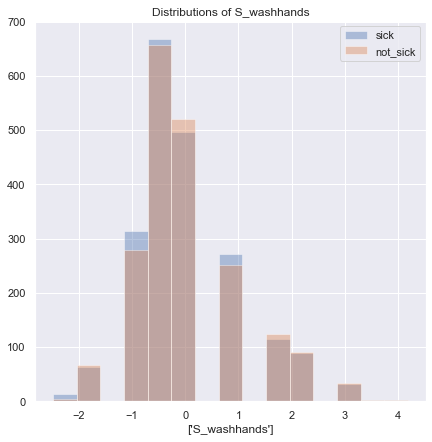

In [186]:
#Data
sick = children_[children_['target'] == 1]
not_sick = children_[children_['target'] == 0]

feature = ['S_washhands']

#Graphical set up
plt.figure(figsize = (7, 7))
sns.distplot(boys[feature], bins = 15, kde = False, axlabel = feature)
sns.distplot(girls[feature], bins = 15, kde = False, axlabel = feature)
plt.title('Distributions of '+ feature[0] )
plt.legend(['sick', 'not_sick'])
plt.show()

In [187]:
from statsmodels.stats.weightstats import ttest_ind
#Some stats before the test
print("Number of samples sick :", len(sick.index))
print("Number of samples not sick :", len(not_sick.index))
print("Standard deviation of samples accepted :", sick['S_washhands'].std(axis = 0))
print("Standard deviation of samples rejected :", not_sick['S_washhands'].std(axis = 0))

# As we see that standard deviation are not equal for both samples we fixe usevar as unequal 
# Then we set value as 0 because the null hyptoesis implies a difference of mean that is 0
# Finaly be definition of the alternative hypothesis we fixe alternative as larger. 

test = ttest_ind(sick['S_washhands'], not_sick['S_washhands'], alternative='two-sided')

print("The t-value is ", test[0])
print("The p-value is ", test[1])

Number of samples sick : 2929
Number of samples not sick : 1164
Standard deviation of samples accepted : 1.0039292739083503
Standard deviation of samples rejected : 0.99034894076371
The t-value is  -1.1334813757202908
The p-value is  0.25707857733750966


We cannot reject the null hypothesis, thus washing hand doesn't seem to improve the children's health

***
# III - Implication of Piso Firme on the health 

We are going to see the effect of Piso Firme on the health based on what we saw previously. We saw that there might be some confounden observations that can affect the naive approach. First, we are going to see the impact with simple statistic tools. Then we will investigate further by doing an observational studies (compute the propensity score and match the treated and control by pair). Finally, we will study the impact of Piso Firme on the balanced data.  

In [86]:
# Define the group control and the treatement groupe
treated = children_.loc[children_['dpisofirme'] == 1] #People concerned by Piso Firme
control = children_.loc[children_['dpisofirme'] == 0] #Control group

In [87]:
# First statistic on the treatement groupe 
treated.target.describe()

count    1981.000000
mean        0.707723
std         0.454924
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64

In [88]:
# First statistic on the control groupe 
control.target.describe()

count    2112.000000
mean        0.723011
std         0.447617
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64

#### Chi-2 Test

We are interested to see if a relation between Piso Firme (*dpisofirme*) and sickness of children (*target*). We will first use a Chi-2 test to test the independance of these 2 variables. We set the null hypothesis as :

$H_0$ : No relationship between the 2 variables 

$H_a$: There exists a relation between the 2 variables


In [89]:
significance = 0.05

#Contingency table
contingency = pd.crosstab(children_['target'], children_['dpisofirme'])
print(contingency)

from scipy.stats import chi2_contingency 

chi_scores = chi2_contingency(contingency)
p_value = chi_scores[1]
print("chi-2 test: p-value %0.3f" % ( p_value))

print("Conclusion :")
if p_value > significance:
    print("   Fail to reject the null hypothesis - we have nothing else to say")
else:
    print("   Reject the null hypothesis - suggest the alternative hypothesis is true")

dpisofirme   0.0   1.0
target                
0.0          585   579
1.0         1527  1402
chi-2 test: p-value 0.294
Conclusion :
   Fail to reject the null hypothesis - we have nothing else to say


#### Z-Test

Now we will use a  Z-test to test the proportion of people in health in control and treatment group. We set the null hypothesis as :

$H_0$ : proportions of sick in treatment = proportions of sick in control

$H_a$: proportions of sick in treatment < proportions of sick in control


In [90]:
from statsmodels.stats.proportion import proportions_ztest

# can we assume anything from our sample
significance = 0.05

# note - the samples do not need to be the same size
nb_sick_treat, sample_size_treat = (treated.target.sum(), len(treated))
nb_sick_control, sample_size_control = (control.target.sum(), len(control))

print("Number of sick in the treatment group",nb_sick_treat)
print("Number of people in the treatment group",sample_size_treat)
print("Number of sick in the control group",nb_sick_control)
print("Number of sick in the control group",sample_size_control)

# check our sample against Ho for Ha != Ho
successes = np.array([nb_sick_treat, nb_sick_control])
samples = np.array([sample_size_treat, sample_size_control])

stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='smaller')

# report
print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))

print("Conclusion :")
if p_value > significance:
    print("   Fail to reject the null hypothesis - we have nothing else to say")
else:
    print("   Reject the null hypothesis - suggest the alternative hypothesis is true")

Number of sick in the treatment group 1402.0
Number of people in the treatment group 1981
Number of sick in the control group 1527.0
Number of sick in the control group 2112
z_stat: -1.083, p_value: 0.139
Conclusion :
   Fail to reject the null hypothesis - we have nothing else to say


**TODO** : conclusion des test

#### Check if the distribution are balanced 

Note a vous : peut etre mettre que les plots avec les feature important 

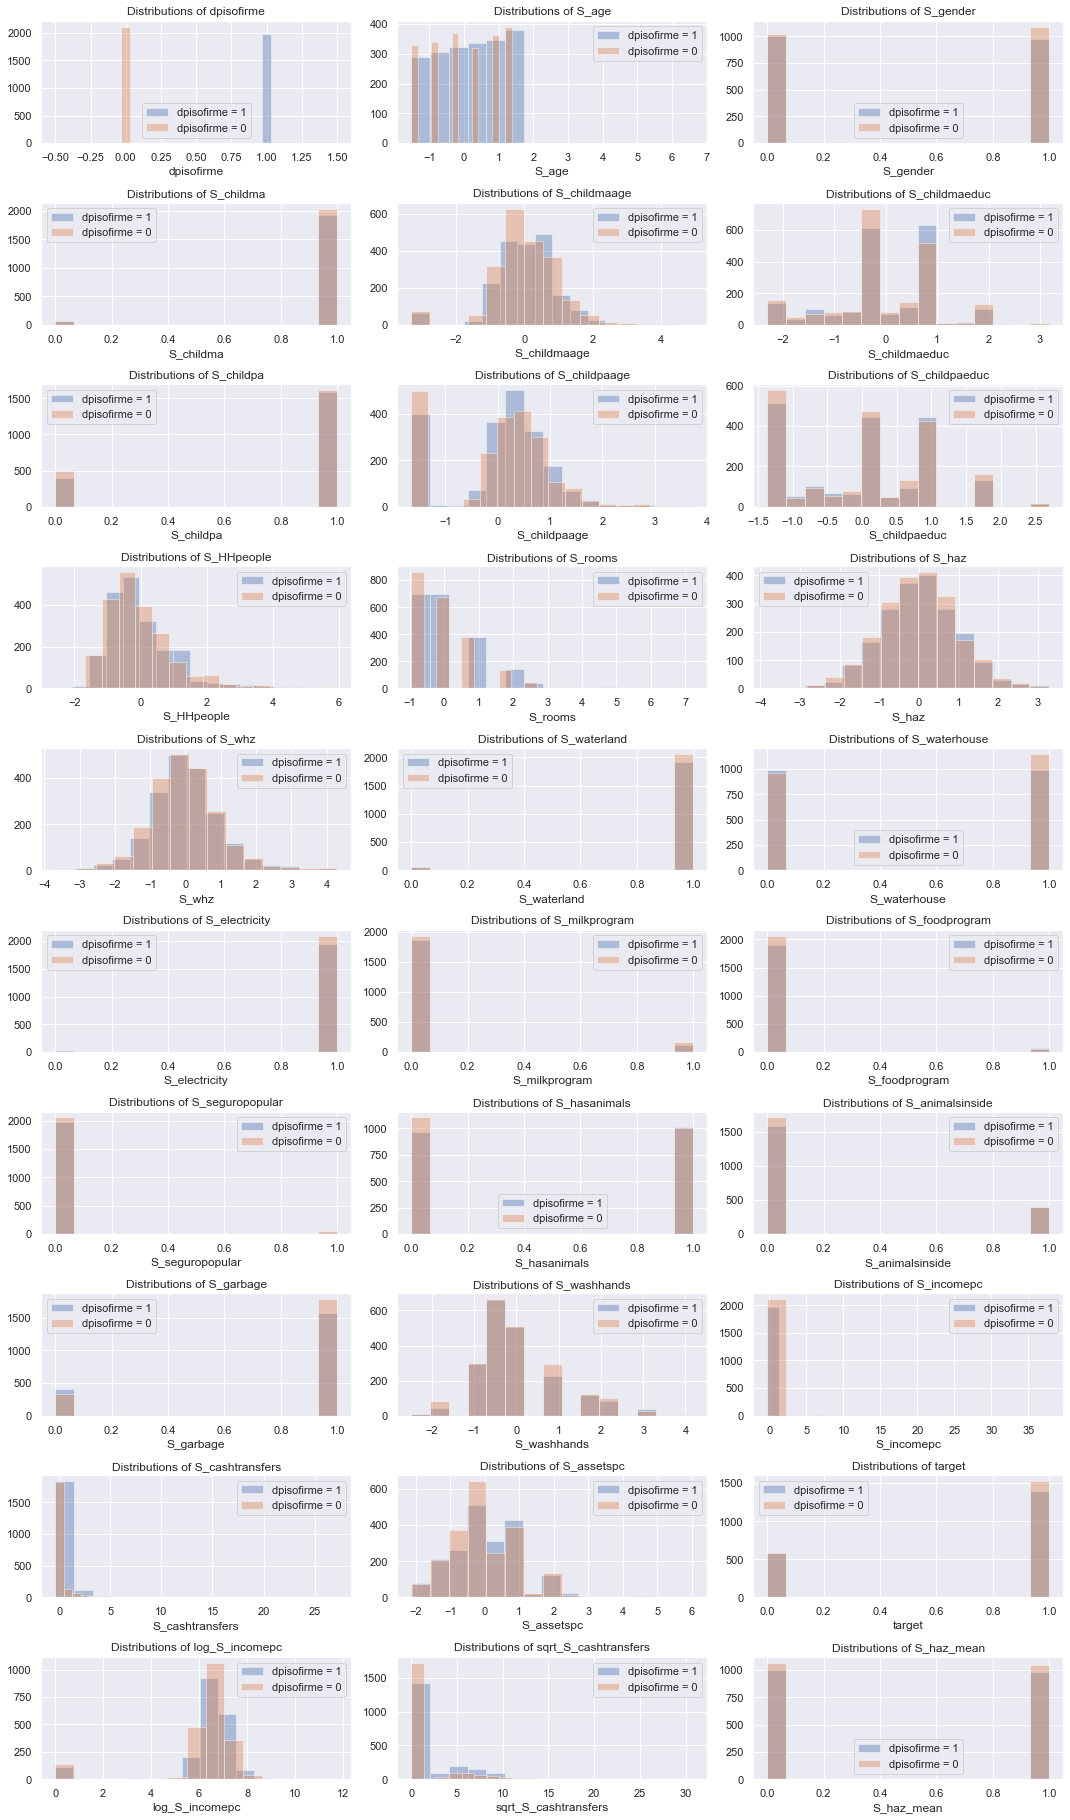

In [91]:
plt.figure(figsize=(15,30))
for idx, feature in enumerate(children_.columns):
    plt.subplot(12, 3, idx+1)
    sns.distplot(treated[feature], bins = 15, kde = False, axlabel = feature)
    sns.distplot(control[feature], bins = 15, kde = False, axlabel = feature)
    ax = plt.gca()
    ax.set_title('Distributions of '+ feature )
    ax.legend(['dpisofirme = 1', 'dpisofirme = 0'])
plt.tight_layout(pad=1.0)
plt.show()

# Matching

To implement the matching we had to first compute the propensity score, and then match the data with pairs having similar propensity scores. 

---

### Propensity score 

To compute the propensity scores we used the logistic regression. This is the most common method to compute propsensity scores. This model is used to probability that an event occurs. 


\begin{equation*}
\frac{e(x_i)}{1-e(x_i)} = ln \frac{Pr(z_i = 1|x_i)}{1 -Pr(z_i = 1|x_i)} = \alpha + \beta^{T} x_i
\end{equation*}

with : 
    $e(x_i) = Pr(z_i = 1|x_i)$
    $e(X_i) = b_0 + b_1 X_1+ ...+ b_i X_i$
    
and 
    $b_0$ : the intercept
    $b_i$ : the regression coefficient i
    $x_i$ : observed value of variables
    $X_i$ : the treatment variables and covariates

The dependent variable, $Z_i$ is binary, equals to 1 for the treatment and 0 for the control.

---

### Matching

Two different methods were implemented:
    
* Without graph: were we computed the similarity between samples and matched them if they had similar propensity scores and if selected features were equal.

* Graph matching: where each sample is adding a weighted edge if the similarity is smaller than a given epsilon. We then did a maximum matching, were the matching contains the largest possible number of edges matching as many nodes as possible. 
    

In [92]:
features = feature_selection_df['Feature'][:15].tolist()
log = children_.drop(['S_cashtransfers', 'S_incomepc'], axis = 1)

In [93]:
#Building the model
log_reg = smf.logit(formula = 'dpisofirme ~ C(target) + S_whz + S_washhands + S_haz + S_childpaeduc + S_assetspc + \
                                sqrt_S_cashtransfers + S_age + S_HHpeople + log_S_incomepc + S_rooms + C(S_hasanimals) + \
                                C(S_gender) + S_childpaage + C(S_animalsinside)', data = log)
res = log_reg.fit()

children_['Propensity_scores'] = res.predict()

Optimization terminated successfully.
         Current function value: 0.684023
         Iterations 4


### Without graph

In [94]:
#Separate the treatment and control groups
treatment_df = children_[children_['dpisofirme'] == 1]
control_df = children_[children_['dpisofirme'] == 0]

#List of index
idx_tr= []
idx_co = []

#Threshold
epsilon = 1e-1

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        if (control_row['S_gender'] == treatment_row['S_gender'])\
            and (control_row['S_waterland'] == treatment_row['S_waterland'])\
            and (control_row['S_waterhouse'] == treatment_row['S_waterhouse'])\
            and (control_row['S_hasanimals'] == treatment_row['S_hasanimals']):
            
            similarity = get_similarity(control_row['Propensity_scores'],treatment_row['Propensity_scores'])
            
            if (similarity < epsilon) and treatment_id not in idx_tr and control_id not in idx_co:
                idx_tr.append(treatment_id)
                idx_co.append(control_id)

#Select the pairs in the original dataset
matching_non = children_.loc[idx_tr +idx_co ]

treat_match = children_.loc[idx_tr]
control_match = children_.loc[idx_co]

In [95]:
treat_match = children_.loc[idx_tr]
control_match = children_.loc[idx_co]

In [96]:
treat_size = len(treatment_df)
control_size = len(control_df)
pair_matching_size = int(len(matching_non)/2)

print("There are :",treat_size," in the treatement groupe ")
print("There are :",control_size," in the control groupe ")
print("There are :",pair_matching_size," pair of matching  ")
print("Thus there are :", min(treat_size-pair_matching_size,control_size-pair_matching_size)," of non match pair ")

There are : 1981  in the treatement groupe 
There are : 2112  in the control groupe 
There are : 1906  pair of matching  
Thus there are : 75  of non match pair 


### With graph (optimal matching)

In [ ]:
import networkx as nx

# Separate the treatment and control groups
treatment_df = children_[children_['dpisofirme'] == 1]
control_df = children_[children_['dpisofirme'] == 0]

# Create an empty undirected graph
G = nx.Graph()

#Threshold
epsilon = 1e-1

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_scores'],treatment_row['Propensity_scores'])

        if similarity < epsilon :
            # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

#### Well balanced ? after matching 

We can study the effect of the matching on the features' distributions.

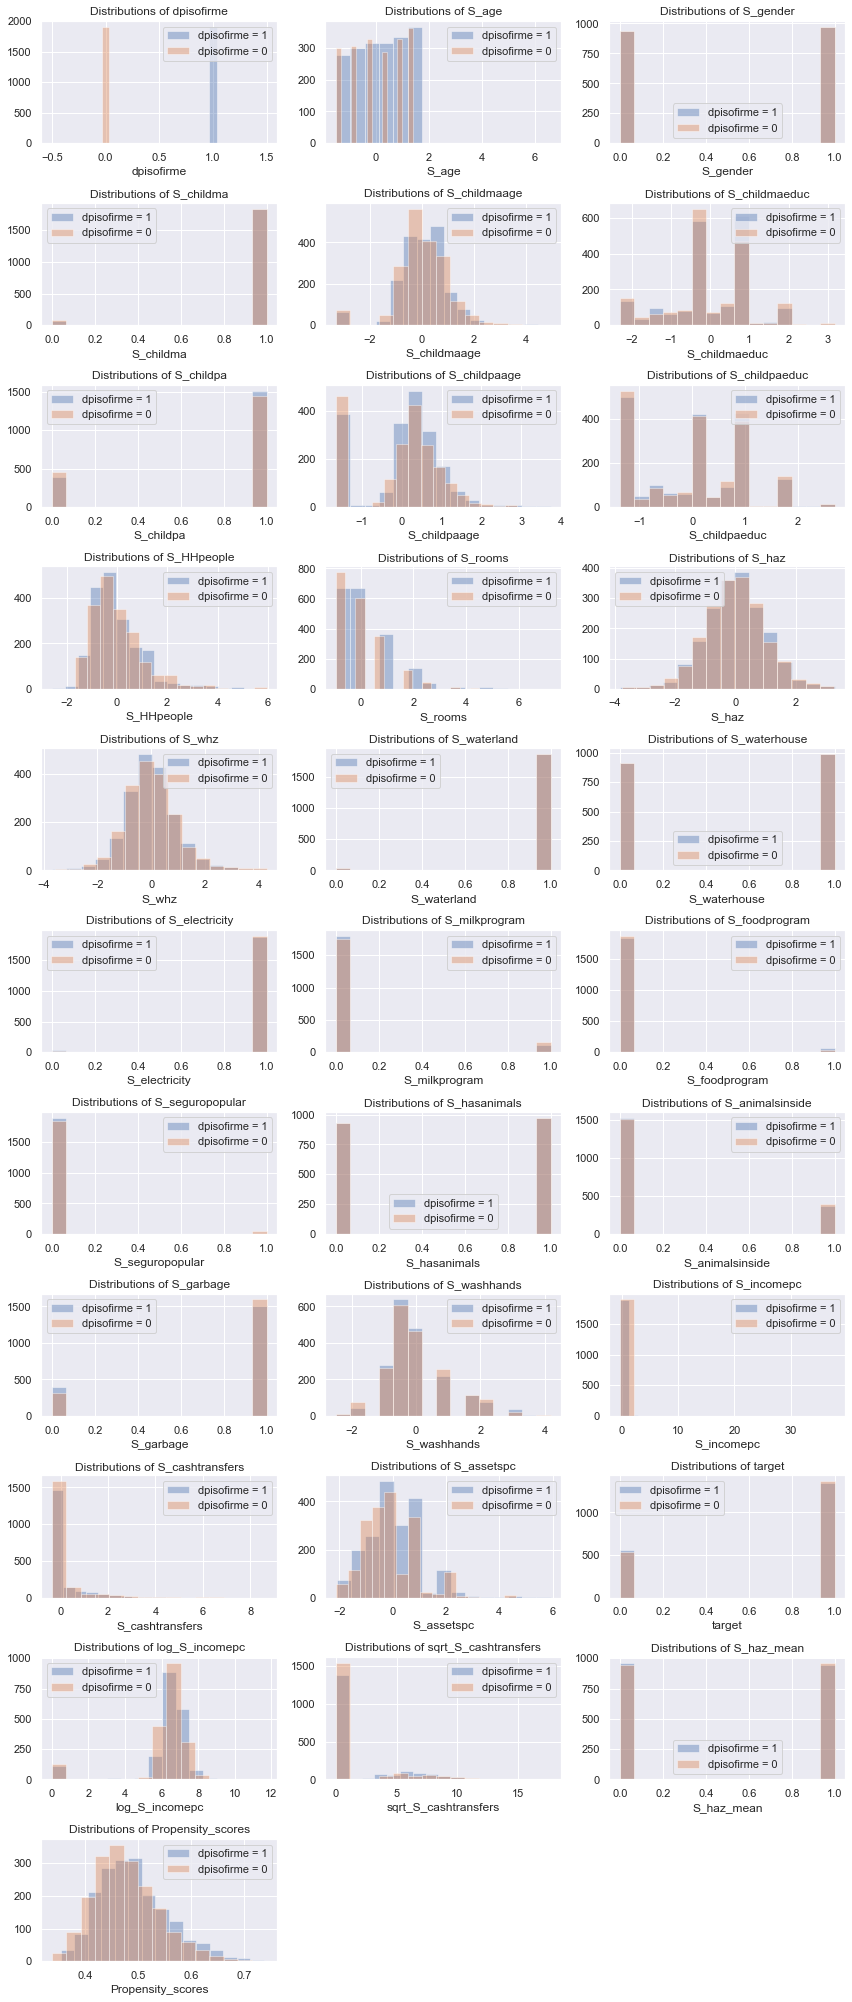

In [97]:
plt.figure(figsize=(12,30))
for idx, feature in enumerate(children_.columns):
    plt.subplot(12, 3, idx+1)
    sns.distplot(treat_match[feature], bins = 15, kde = False, axlabel = feature)
    sns.distplot(control_match[feature], bins = 15, kde = False, axlabel = feature)
    ax = plt.gca()
    ax.set_title('Distributions of '+ feature )
    ax.legend(['dpisofirme = 1', 'dpisofirme = 0'])
plt.tight_layout(pad=1.0)
plt.show()

#### Compute the ATE :

In [98]:
#Calculate ATE
diff_tr_co = treat_match.target.values-control_match.target.values
ATE = np.mean(diff_tr_co)
print(np.mean(ATE))
print("According to our match, the estimate effect of the treatment is ", ATE)
CI = bootstrap_CI_mean(diff_tr_co,500)
print("The 95% CI is : [", round(CI[0],3),",",round(CI[1],3),"]")

-0.00944386149003148
According to our match, the estimate effect of the treatment is  -0.00944386149003148
The 95% CI is : [ -0.036 , 0.018 ]


It seems that the Piso Firme program doesn't affect the children health considerably 

#### Effect of the piso firme on subgroup

A treatment effect is called "heterogenous" if it affects different individuals differently (heterogeneously), One way to look for heterogeneous treatment effects is to divide the study data into subgroups , and see if the average treatment effects are different by subgroup. A per-subgroup ATE is called a "conditional average treatment effect" (CATE), i.e. the ATE conditioned on membership in the subgroup. Thus we will study the implication of depiso frime on :
  - Baby ( younger children )
  - has animals 
  - small incomes per capita 
  - boy and girls 

In [99]:
def sub_group_ATE(subgroup):
    CATE = []
    CATE_CI = []
    
    for condition in subgroup :
        
        children_tmp = children_.query(condition).copy()
        
        treatment_df = children_tmp[children_tmp['dpisofirme'] == 1]
        control_df = children_tmp[children_tmp['dpisofirme'] == 0]

        #List of index
        idx_tr= []
        idx_co = []

        #Threshold
        epsilon = 1e-1

        # Loop through all the pairs of instances
        for control_id, control_row in control_df.iterrows():
            for treatment_id, treatment_row in treatment_df.iterrows():

                similarity = get_similarity(control_row['Propensity_scores'],treatment_row['Propensity_scores'])

                if (similarity < epsilon) and treatment_id not in idx_tr and control_id not in idx_co:
                    idx_tr.append(treatment_id)
                    idx_co.append(control_id)

        #Select the pairs in the original dataset
        balanced_df_tmp = children_tmp.loc[idx_tr +idx_co ]

        treat_match_tmp = children_tmp.loc[idx_tr]
        control_match_tmp = children_tmp.loc[idx_co]
        
        diff_tr_co = treat_match_tmp.target.values-control_match_tmp.target.values
        ATE_tmp = np.mean(diff_tr_co)
        CI_tmp = bootstrap_CI_mean(diff_tr_co,500)
        
        CATE.append(ATE_tmp)
        CATE_CI.append(CI_tmp)
        
    return CATE, CATE_CI

In [100]:
# Creating subgroups fro income and age
percentile_age_25 = np.percentile(children_.S_age,25)
percentile_income_50 = np.percentile(children_.log_S_incomepc,50)

subgroup = ["S_age< @percentile_age_25" , "S_hasanimals == 1" , " log_S_incomepc < @percentile_income_50"," S_gender == 1","S_gender == 0" ]


In [101]:
#Compute CATE
CATE, CATE_CI = sub_group_ATE(subgroup)

In [111]:
Results_CATE = pd.DataFrame(CATE_CI,columns=['lower CI','upper CI'],index=subgroup)
Results_CATE["CATE"] = CATE

In [112]:
Results_CATE[["CATE",'lower CI','upper CI']]

,CATE,lower CI,upper CI
S_age< @percentile_age_25,-0.024221,-0.103806,0.057180
S_hasanimals == 1,-0.014881,-0.057540,0.021825
log_S_incomepc < @percentile_income_50,0.011931,-0.028200,0.057592
S_gender == 1,-0.033916,-0.072482,0.005139
S_gender == 0,0.016882,-0.018868,0.056132


The Male subgroup is the only significant CATE. To look at this more closely we look at the interaction between gender and piso firme using a logistic regression.

In [85]:

#Building the model
log_reg = smf.logit(formula = 'target ~ C(dpisofirme)+ C(S_gender)*C(dpisofirme) + S_whz + S_washhands + S_haz + S_childpaeduc + S_assetspc + \
                                sqrt_S_cashtransfers + S_age + S_HHpeople + log_S_incomepc + S_rooms + C(S_hasanimals) + \
                                C(S_gender) + S_childpaage + C(S_animalsinside)', data = children_)
res = log_reg.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.589321
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 4093
Model:                          Logit   Df Residuals:                     4076
Method:                           MLE   Df Model:                           16
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:                 0.01294
Time:                        22:37:48   Log-Likelihood:                -2412.1
converged:                       True   LL-Null:                       -2443.7
Covariance Type:            nonrobust   LLR p-value:                 1.460e-07
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.7588

Interaction between gender and piso firme seems to have a huge effect due to large coefficient and his p-value is nearly statiscaly significant 